<a href="https://colab.research.google.com/github/SebastienLiger/Portfolio-Finance/blob/Finance/Equity_Growth_Fund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [377]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from tabulate import tabulate
from datetime import datetime

In [378]:
tickers = ["SAP", "OR.PA", "SQI.PA", "MA", "FDE.PA", "SU.PA", "DSY.PA", "MC.PA",
    "AIR.PA", "HO.PA", "GE", "NEOEN.PA", "2FE.DE", "RBT.PA", "AI.PA", "GTT.PA", "RMS.PA", "NVDA", "BLQA.F", "TSLA"]

In [379]:
tickers_to_names = {
    "SAP": "SAP",
    "OR.PA": "L'Oréal",
    "SQI.PA": "SQLI",
    "MA": "MasterCard",
    "FDE.PA": "La Française de l'Énergie",
    "SU.PA": "Schneider Electric",
    "DSY.PA": "Dassault Systèmes",
    "MC.PA": "LVMH",
    "AIR.PA": "Airbus",
    "HO.PA": "Thales",
    "GE": "General Electric",
    "NEOEN.PA": "Neoen",
    "2FE.DE": "Ferrari",
    "RBT.PA": "Robertet",
    "AI.PA": "Air Liquide",
    "GTT.PA": "Gaztransport & Technigaz",
    "RMS.PA": "Hermès International",
    "NVDA": "NVIDIA Corporation",
    "BLQA.F": "BlackRock",
    "TSLA": "Tesla, Inc."
}

In [380]:
# CALCUL NET INCOME 2022 / PRICES / MARKET CAP

import pandas as pd
import yfinance as yf
from tabulate import tabulate

# Dictionnaire des taux de change vers l'euro
taux_de_change = {
    "USD": 0.9480,
    "EUR": 1
}

results = []
headers = ['Ticker', 'Bénéfice Net 2022', 'Prix au 03/01/23', 'Market Cap au 03/01/23']

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    company_name = tickers_to_names.get(ticker_symbol, ticker_symbol)
    currency = ticker.info.get('currency', 'USD')  # Assumer USD par défaut

    try:
        financials = ticker.financials.T
        financials_in_range = financials[(financials.index > pd.Timestamp('2022-06-29')) & (financials.index <= pd.Timestamp('2023-02-15'))]
        net_income_2022 = "Non disponible"
        if not financials_in_range.empty:
            net_income_2022 = financials_in_range.iloc[-1]['Net Income']

        # Conversion des montants en euros si nécessaire
        exchange_rate = taux_de_change.get(currency, 1)
        if pd.notna(net_income_2022) and net_income_2022 != "Non disponible":
            net_income_2022 *= exchange_rate

        net_income_2022_formatted = f"{net_income_2022:,.0f}€" if pd.notna(net_income_2022) else net_income_2022

        stock_price = ticker.history(start="2023-01-03", end="2023-01-04")
        closing_price = stock_price['Close'].iloc[0] if not stock_price.empty else "Non disponible"
        closing_price_formatted = f"{closing_price:,.2f}€" if pd.notna(closing_price) else closing_price

        shares_outstanding = ticker.info.get('sharesOutstanding')
        market_cap = closing_price * shares_outstanding if pd.notna(closing_price) and pd.notna(shares_outstanding) else "Non disponible"
        if pd.notna(market_cap) and market_cap != "Non disponible":
            market_cap *= exchange_rate

        market_cap_formatted = f"{market_cap:,.0f}€" if pd.notna(market_cap) else market_cap

        results.append([
            company_name,
            net_income_2022_formatted,
            closing_price_formatted,
            market_cap_formatted,
        ])
    except Exception as e:
        print(f"An error occurred for {ticker_symbol}: {e}")

results_sorted = sorted(
    results,
    key=lambda x: float(x[1].replace('€', '').replace(',', '').replace('Non disponible', '-inf')) if x[1] != "Non disponible" else float('-inf'),
    reverse=True
)

print(tabulate(results_sorted, headers=headers, tablefmt="grid"))

+---------------------------+---------------------+--------------------+--------------------------+
| Ticker                    | Bénéfice Net 2022   | Prix au 03/01/23   | Market Cap au 03/01/23   |
+===========================+=====================+====================+==========================+
| LVMH                      | 14,084,000,000€     | 691.86€            | 345,614,062,115€         |
+---------------------------+---------------------+--------------------+--------------------------+
| Tesla, Inc.               | 11,928,684,000€     | 108.10€            | 326,373,454,485€         |
+---------------------------+---------------------+--------------------+--------------------------+
| MasterCard                | 9,413,640,000€      | 343.68€            | 301,607,101,609€         |
+---------------------------+---------------------+--------------------+--------------------------+
| L'Oréal                   | 5,706,600,000€      | 333.70€            | 178,440,053,586€         |


In [381]:
# CALCUL PRICE EARNING 2022

pe_results = []
headers = ['Ticker', 'Price Earnings']

for ticker_symbol in tickers:
    ticker = yf.Ticker(ticker_symbol)
    company_name = tickers_to_names.get(ticker_symbol, ticker_symbol)

    try:
        # Fetch the financials and get the latest available net income within the date range
        financials = ticker.financials.T
        financials_in_range = financials[(financials.index > pd.Timestamp('2022-06-29')) & (financials.index <= pd.Timestamp('2023-02-15'))]
        net_income_2022 = financials_in_range.iloc[-1]['Net Income'] if not financials_in_range.empty else None

        # Fetch the stock price on 2023-01-03 and calculate market cap
        stock_price = ticker.history(start="2023-01-03", end="2023-01-04")
        closing_price = stock_price['Close'].iloc[0] if not stock_price.empty else None
        shares_outstanding = ticker.info.get('sharesOutstanding')
        market_cap = closing_price * shares_outstanding if pd.notna(closing_price) and pd.notna(shares_outstanding) else None

        # Calculate the Price Earnings ratio
        if market_cap is not None and net_income_2022 is not None and net_income_2022 != 0:
            pe_ratio = market_cap / net_income_2022
            # Format the PE ratio to two decimal places
            pe_ratio_formatted = f"{pe_ratio:.2f}"
        else:
            pe_ratio_formatted = "Non disponible"

        # Append the results
        pe_results.append([
            company_name,
            pe_ratio_formatted
        ])

    except Exception as e:
        pe_ratio_formatted = "Non disponible"
        print(f"An error occurred for {ticker_symbol}: {e}")
        pe_results.append([
            company_name,
            pe_ratio_formatted
        ])

# Sort the PE results
pe_results_sorted = sorted(pe_results, key=lambda x: float('-inf') if x[1] == "Non disponible" else float(x[1]), reverse=True)

# Display the PE table
pe_table = tabulate(pe_results_sorted, headers=headers, tablefmt="grid")
print(pe_table)

+---------------------------+------------------+
| Ticker                    |   Price Earnings |
+===========================+==================+
| General Electric          |           169.8  |
+---------------------------+------------------+
| Neoen                     |           115.13 |
+---------------------------+------------------+
| NVIDIA Corporation        |            81.89 |
+---------------------------+------------------+
| SAP                       |            52.27 |
+---------------------------+------------------+
| Dassault Systèmes         |            47.84 |
+---------------------------+------------------+
| Hermès International      |            45.96 |
+---------------------------+------------------+
| Ferrari                   |            39.11 |
+---------------------------+------------------+
| MasterCard                |            32.04 |
+---------------------------+------------------+
| L'Oréal                   |            31.27 |
+-------------------

In [382]:
# FIRST PART : HISTORICAL DATA
# HISTORICAL PRICES BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Définir les dates de début et de fin
start_date = "2019-01-01"
end_date = "2023-01-01"

# Télécharger les données
tickers = list(tickers_to_names.keys())
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Remplir les valeurs manquantes
data_filled = data.fillna(method='ffill')

# Convertir l'index en format de date souhaité
data_filled.index = data_filled.index.strftime('%d %b %Y')

# Remplacer les tickers par les noms des sociétés dans les en-têtes
data_filled.columns = [tickers_to_names.get(ticker, ticker) for ticker in data_filled.columns]

# Sélectionner les 5 premières et les 5 dernières lignes pour l'affichage
data_subset = pd.concat([data_filled.head(5), data_filled.tail(5)])

# Formatage des valeurs sans pourcentage ni couleurs
formatted_df = data_subset.style.format("{:.2f}€")

# Afficher le DataFrame formaté
formatted_df

[*********************100%%**********************]  20 of 20 completed


In [383]:
# HISTORICAL DAILY RETURN BY COMPANY FROM 2019-01-01 TO 2023-01-01

# tickers_to_names est aussi déjà défini
data_filled.index = pd.to_datetime(data_filled.index)
# Filtrer pour exclure les week-ends
data_filled_weekdays = data_filled[data_filled.index.dayofweek < 5]

# Calcul des rendements quotidiens en ne prenant en compte que les jours où il y a eu des variations
daily_returns = np.log(data_filled_weekdays / data_filled_weekdays.shift(1)).dropna()

daily_returns.index = daily_returns.index.strftime('%d %b %Y')

# Fonction pour colorer les valeurs positives en vert et négatives en rouge
def color_positive_green(val):
    color = 'green' if val > 0 else 'red'
    return f'color: {color}'

# Fonction pour formater les nombres en pourcentage avec 3 décimales
def format_percentage(val):
    return f'{val:.2%}'

# Remplacer les tickers par les noms des sociétés dans les en-têtes
daily_returns.columns = [tickers_to_names.get(ticker, ticker) for ticker in daily_returns.columns]

# Sélectionner les 10 premières et 10 dernières lignes
subset_daily_returns = pd.concat([daily_returns.head(10), daily_returns.tail(10)])

# Appliquer le style et le formatage
styled_df = subset_daily_returns.style.applymap(color_positive_green).format(format_percentage)

# Afficher le DataFrame stylisé
styled_df

[*********************100%%**********************]  20 of 20 completed


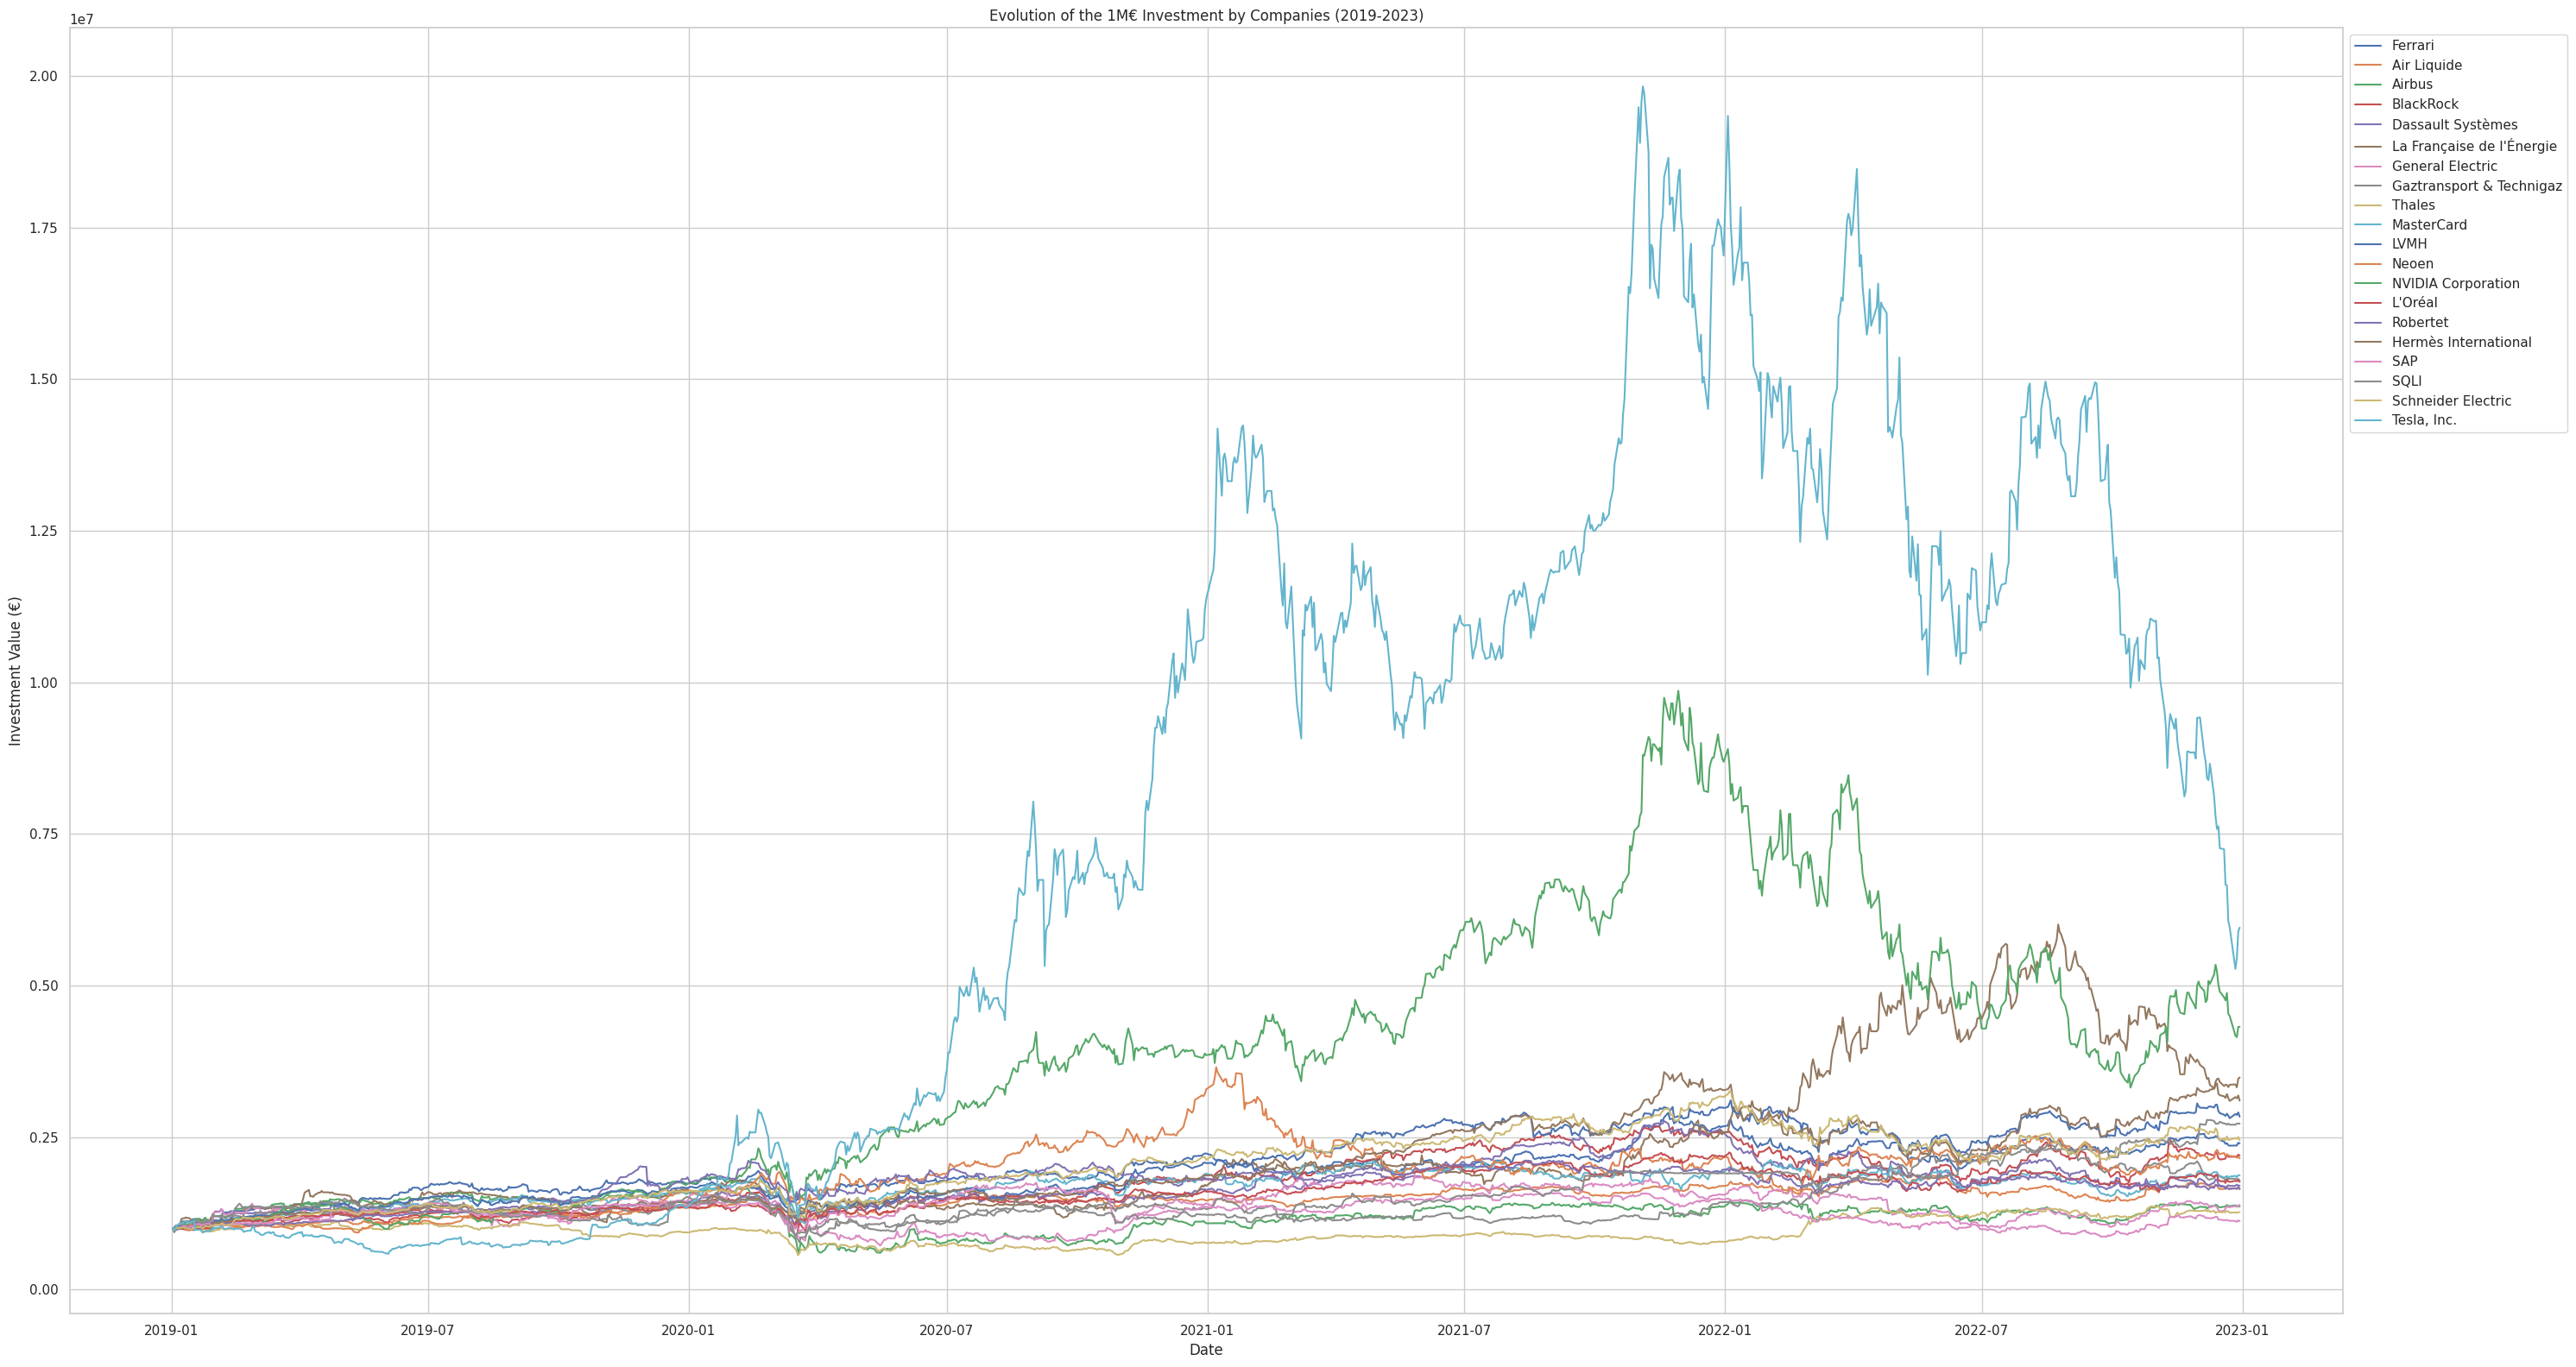

In [384]:
# SIMULATION 1,000,000 EUROS INVESTED FROM 01-01-2019 TO 01-01-2023 PER COMPANY

# Dates de début et de fin
start_date = "2019-01-01"
end_date = "2023-01-01"

# Télécharger les données
data = yf.download(list(tickers_to_names.keys()), start=start_date, end=end_date)['Adj Close']

# Remplissez les valeurs manquantes en propageant la dernière valeur observée
data.ffill(inplace=True)

# Si le 1er janvier 2019 n'est pas dans les données, utilisez la première date disponible
if start_date not in data.index:
    start_date = data.index[0]

# Calculer le montant d'actions acheté avec 1 million d'euros pour chaque société au début
initial_prices = data.loc[start_date]
shares_bought = 1e6 / initial_prices

# Calculer la valeur de l'investissement sur la période
investment_value = data * shares_bought

# Afficher l'évolution de l'investissement
plt.figure(figsize=(30, 16))
for column in investment_value.columns:
    plt.plot(investment_value.index, investment_value[column], label=tickers_to_names[column])

plt.title('Evolution of the 1M€ Investment by Companies (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Investment Value (€)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

[*********************100%%**********************]  20 of 20 completed


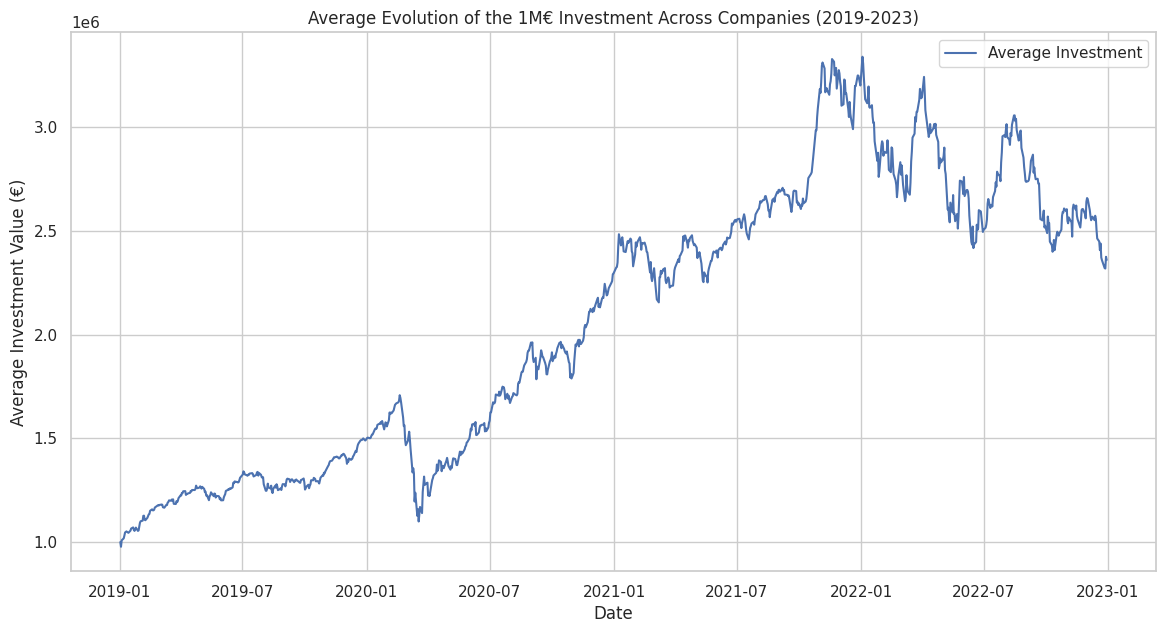

In [385]:
# AVERAGE PERFORMANCE FROM 01-01-2019 TO 01-01-2023

# Download the data
data = yf.download(list(tickers_to_names.keys()), start=start_date, end=end_date)['Adj Close']

# Forward fill the missing values
data.ffill(inplace=True)

# Check if the start date is present in the data, otherwise use the first available date
if start_date not in data.index:
    start_date = data.index[0]

# Calculate the amount of shares bought with 1 million euros for each company at the start
initial_prices = data.loc[start_date]
shares_bought = 1e6 / initial_prices

# Calculate the investment value over the period for each company
investment_value = data * shares_bought

# Calculate the average of the investment values across all companies for each day
average_investment_value = investment_value.mean(axis=1)

# Plot the average curve of the investment values
plt.figure(figsize=(14, 7))
plt.plot(average_investment_value.index, average_investment_value, label='Average Investment')

plt.title('Average Evolution of the 1M€ Investment Across Companies (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Average Investment Value (€)')
plt.legend()
plt.grid(True)
plt.show()

In [386]:
# VALUE OF THIS AVERAGE PERFORMANCE PER DAY

# Convert the average investment values to a DataFrame for display
average_investment_daily = pd.DataFrame(average_investment_value, columns=['Average Investment'])

# Round the values to whole numbers and format with spaces as thousand separators and append the euro sign
average_investment_daily['Average Investment'] = average_investment_daily['Average Investment'].round(0).apply(lambda x: f"{x:,.0f} €".replace(',', ' '))

# Display the first and last 10 values of the DataFrame
first_ten = average_investment_daily.head(10)
last_ten = average_investment_daily.tail(10)

# Combine the first and last ten rows for display
combined_first_last = pd.concat([first_ten, last_ten])

# Display the combined DataFrame
print(combined_first_last)

           Average Investment
Date                         
2019-01-02        1 000 000 €
2019-01-03          977 515 €
2019-01-04        1 008 360 €
2019-01-07        1 017 899 €
2019-01-08        1 030 671 €
2019-01-09        1 046 096 €
2019-01-10        1 048 888 €
2019-01-11        1 051 458 €
2019-01-14        1 044 633 €
2019-01-15        1 048 514 €
2022-12-16        2 462 890 €
2022-12-19        2 448 447 €
2022-12-20        2 406 987 €
2022-12-21        2 438 517 €
2022-12-22        2 370 956 €
2022-12-23        2 358 367 €
2022-12-27        2 320 085 €
2022-12-28        2 318 176 €
2022-12-29        2 374 649 €
2022-12-30        2 359 370 €


In [387]:
# RETURN OF THIS AVERAGE PERFORMANCE FROM 01-01-2019 TO 01-01-2023

# Convert the formatted strings back to floats for calculation
average_investment_daily['Average Investment Numeric'] = average_investment_daily['Average Investment'].str.replace(' €', '').str.replace(' ', '').astype(float)

# Get the first and the last investment value
first_value = average_investment_daily['Average Investment Numeric'].iloc[0]
last_value = average_investment_daily['Average Investment Numeric'].iloc[-1]

# Calculate the return
investment_return = (last_value - first_value) / first_value

# Display the return as a percentage
investment_return_percentage = f"{investment_return:.2%}"

investment_return_percentage

'135.94%'

In [388]:
# ANNUALIZED RETURN OF THIS AVERAGE PERFORMANCE FROM 01-01-2019 TO 01-01-2023

# Convert the formatted strings back to floats for calculation
average_investment_daily['Average Investment Numeric'] = average_investment_daily['Average Investment'].str.replace(' €', '').str.replace(' ', '').astype(float)

# Get the first and the last investment value
first_value = average_investment_daily['Average Investment Numeric'].iloc[0]
last_value = average_investment_daily['Average Investment Numeric'].iloc[-1]

# Calculate the total return
total_investment_return = (last_value - first_value) / first_value

# Get the number of years between the first and last date to annualize the return
total_days = (average_investment_daily.index[-1] - average_investment_daily.index[0]).days
years = total_days / 365.25

# Calculate the annualized return
annualized_return = (1 + total_investment_return) ** (1 / years) - 1

# Display the annualized return as a percentage
annualized_return_percentage = f"{annualized_return:.2%}"

annualized_return_percentage

'23.99%'

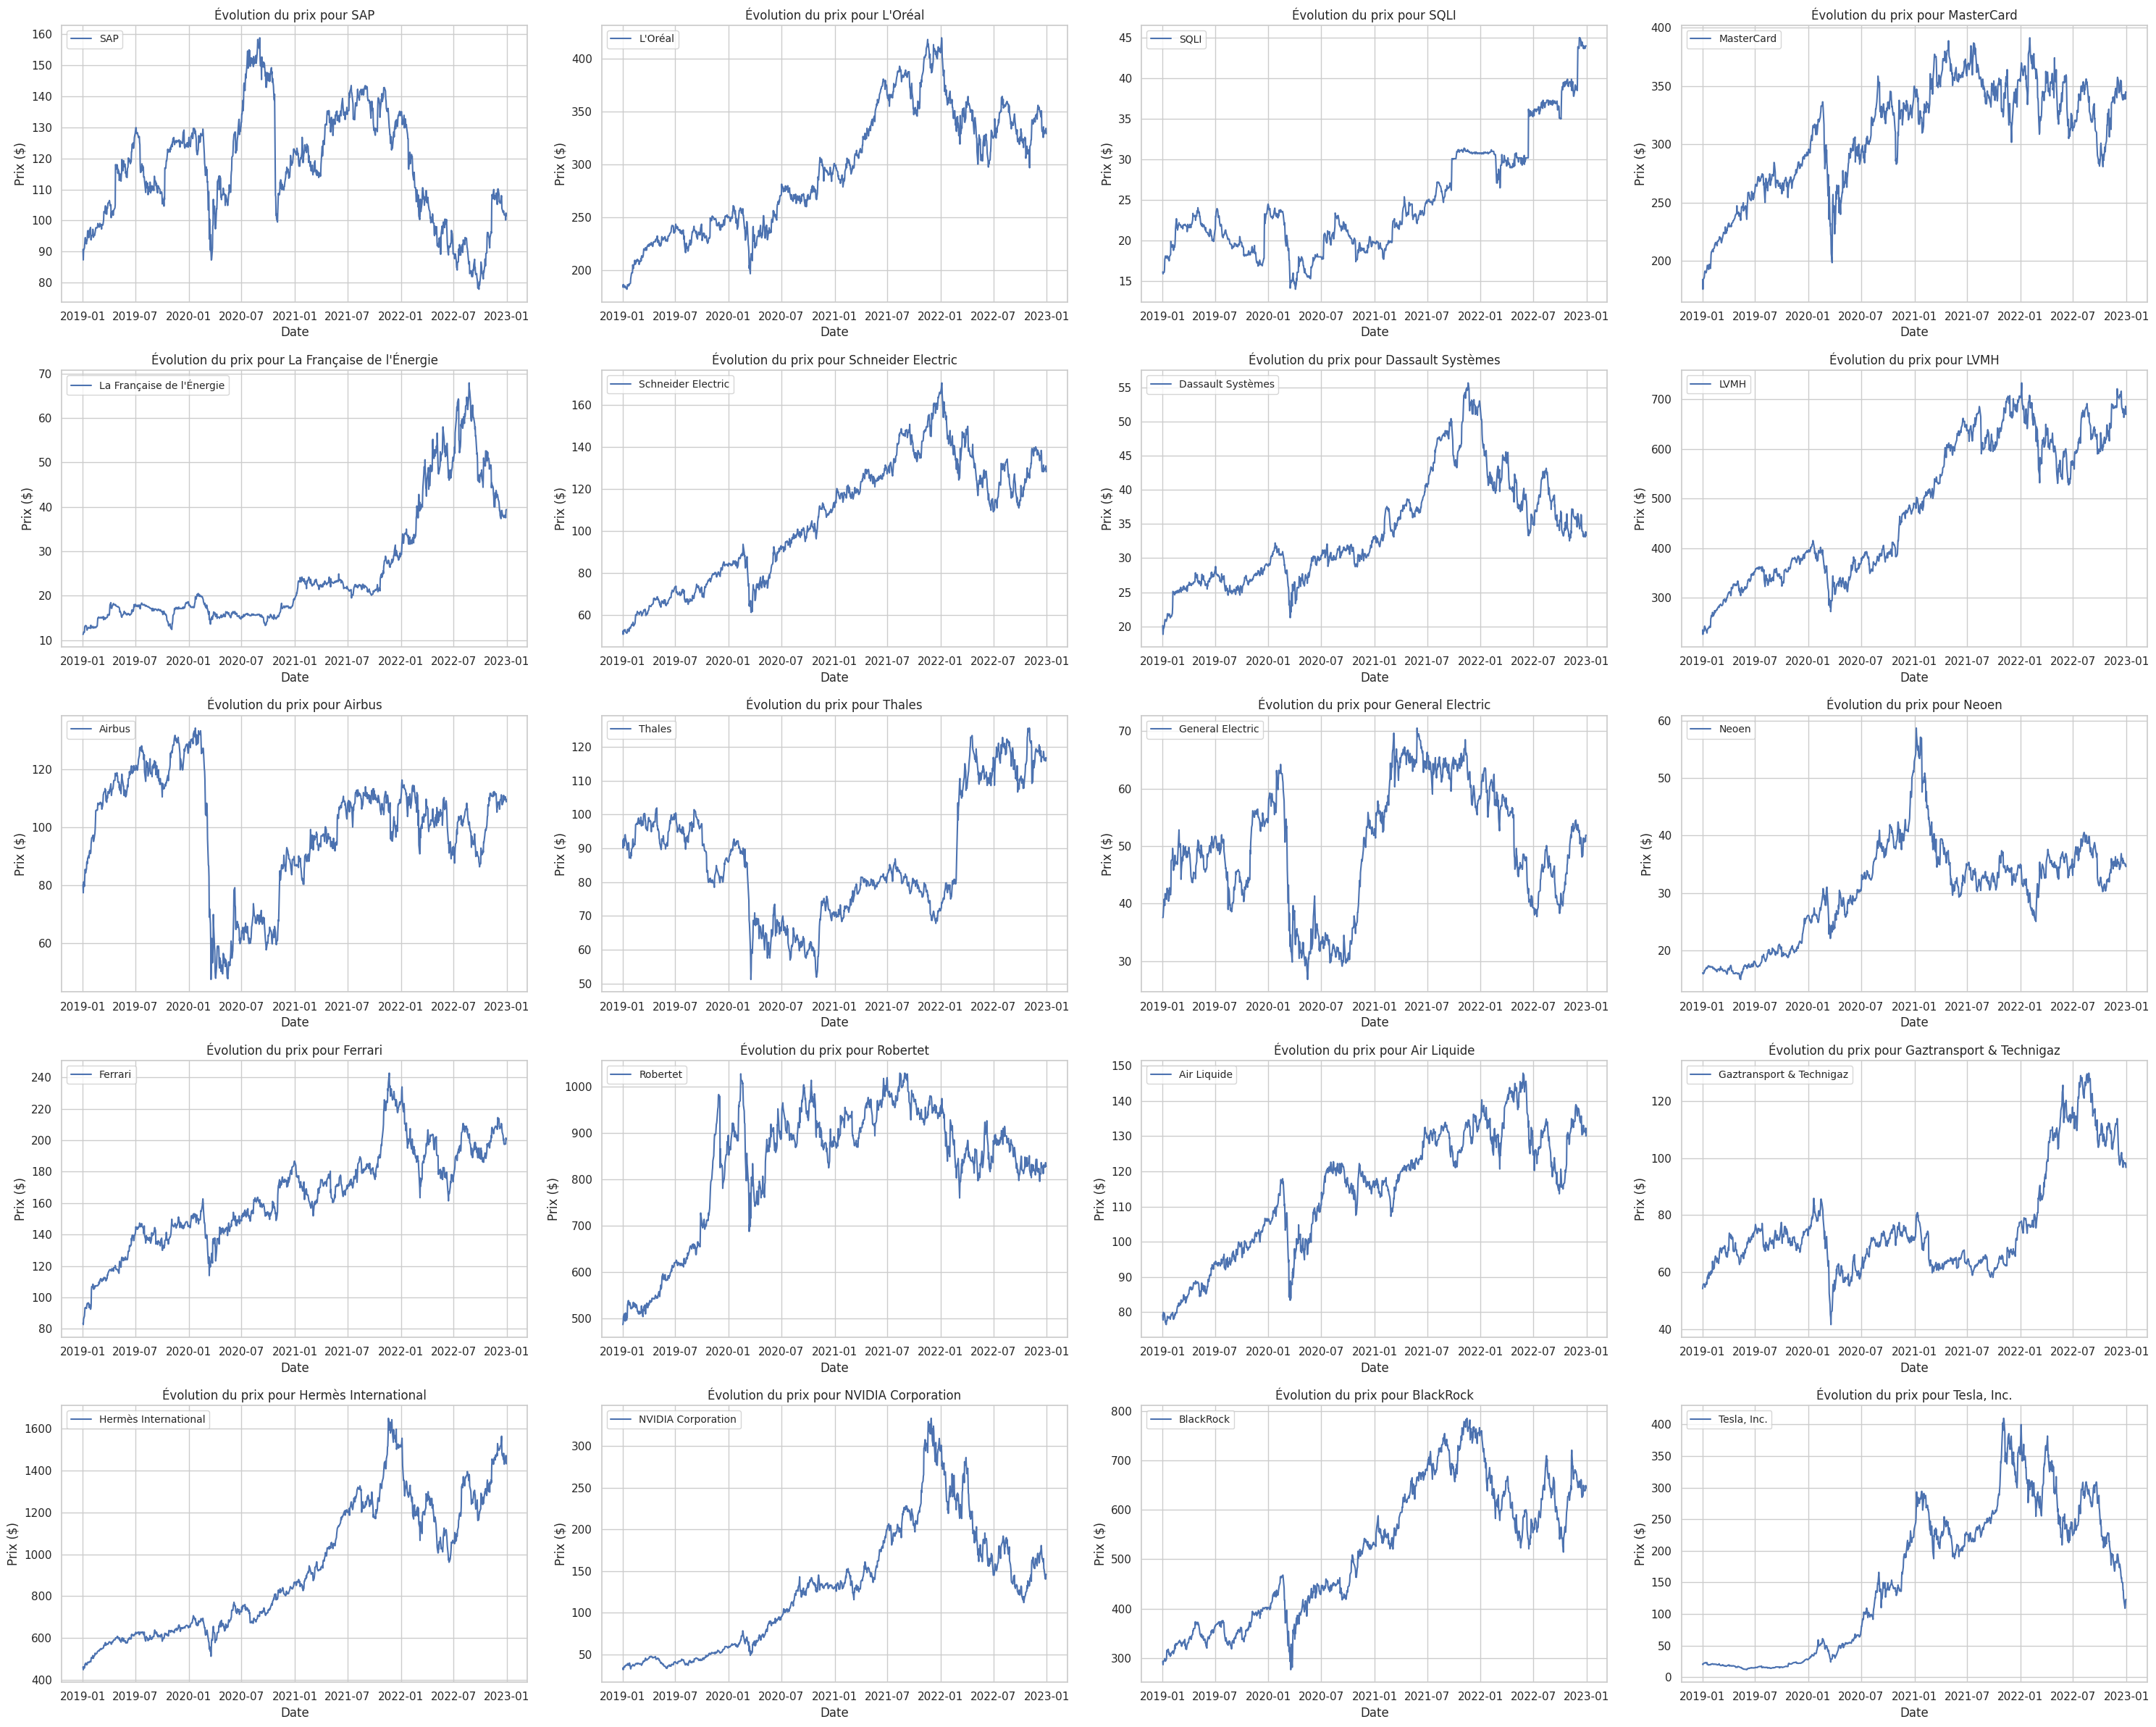

In [389]:
# HISTORICAL GRAPH BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Remplacer les valeurs manquantes par celles de la veille
data = data.fillna(method='ffill')

# Déterminer le nombre de lignes et de colonnes pour la disposition des sous-graphiques
num_plots = len(tickers_to_names)
num_rows = (num_plots - 1) // 4 + 1  # Nombre de lignes arrondi vers le haut
num_cols = min(num_plots, 4)

# Tracer l'évolution du prix pour chaque société dans un seul graphique avec plusieurs sous-graphiques
plt.figure(figsize=(30, 24))

for i, (ticker, name) in enumerate(tickers_to_names.items(), start=1):
    ax = plt.subplot(num_rows, num_cols, i)
    ax.plot(data.index, data[ticker], label=name)
    ax.set_title(f'Évolution du prix pour {name}')  # Utiliser set_title au lieu de title.set_text
    ax.set_xlabel('Date')
    ax.set_ylabel('Prix ($)')
    ax.grid(True)
    ax.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

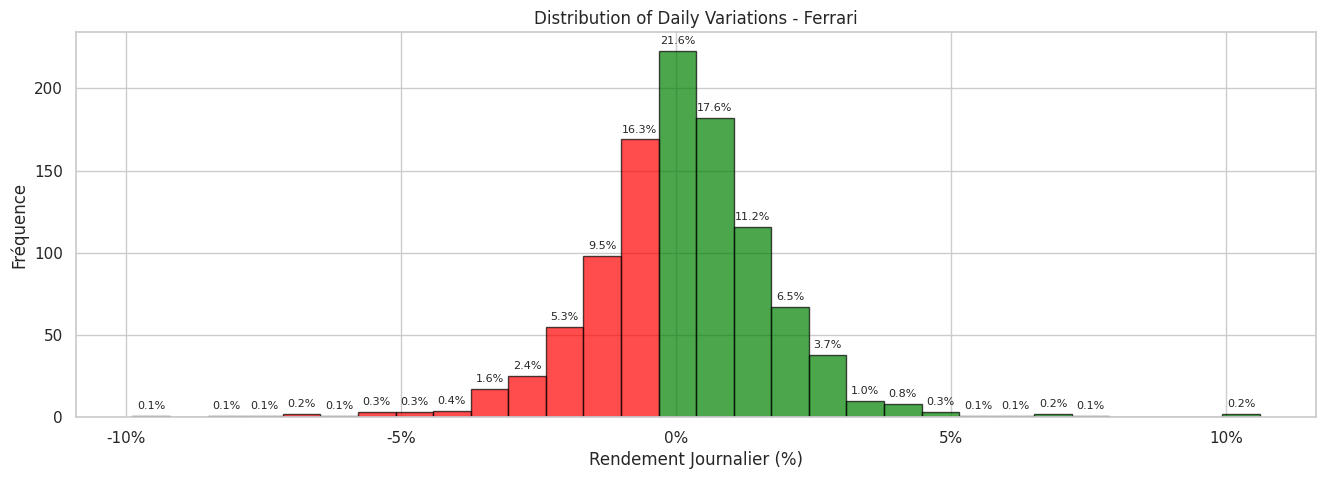

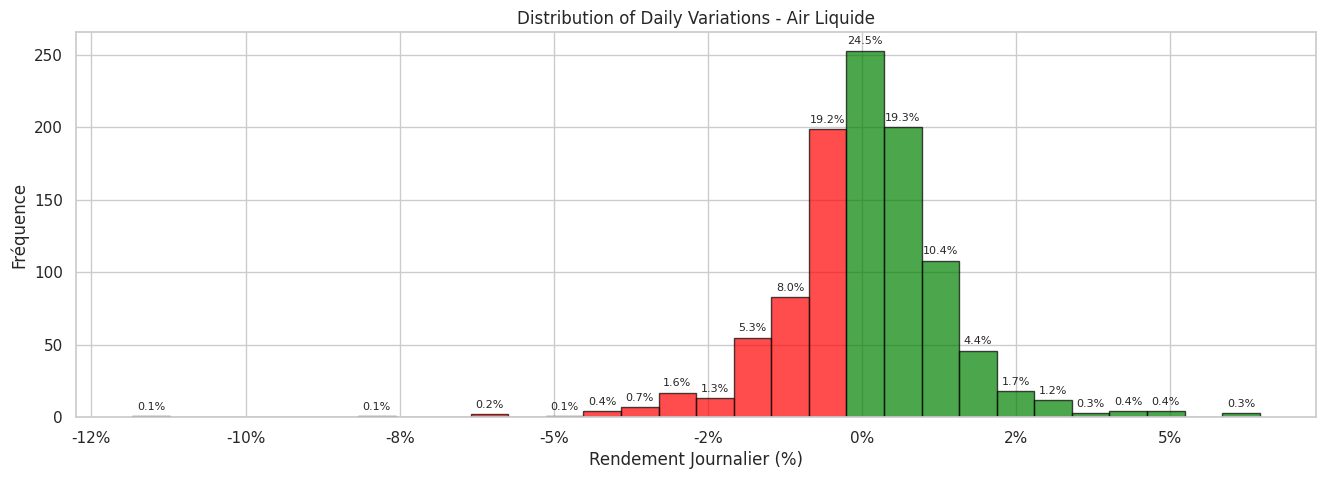

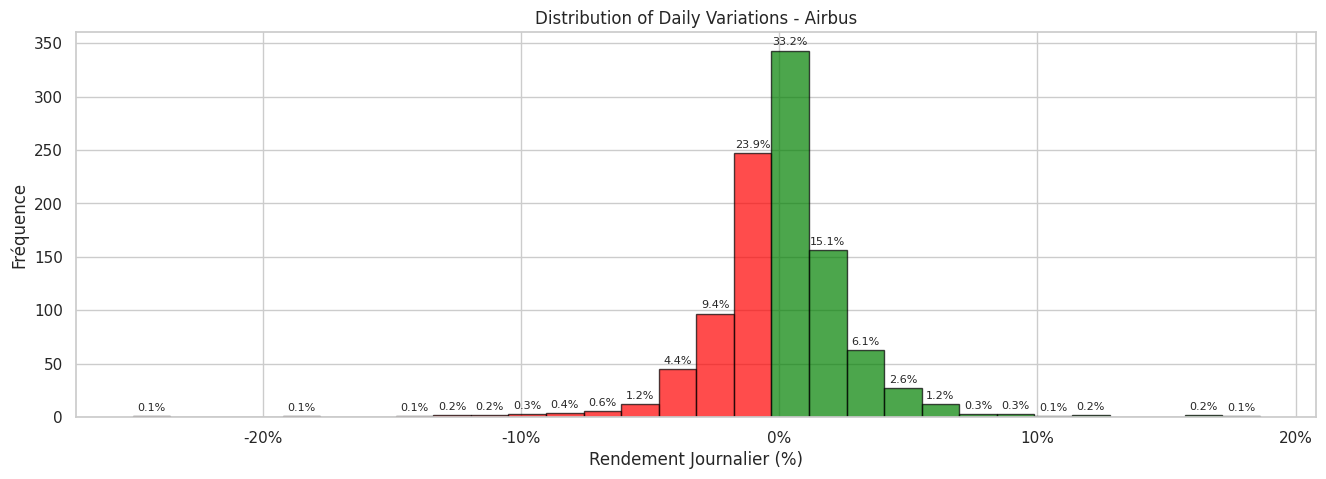

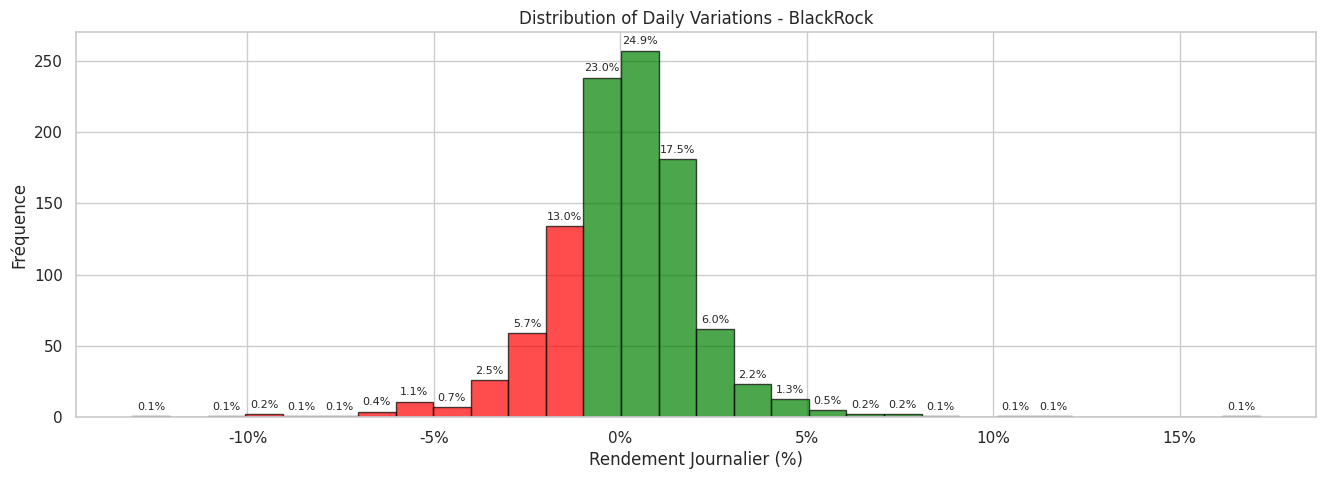

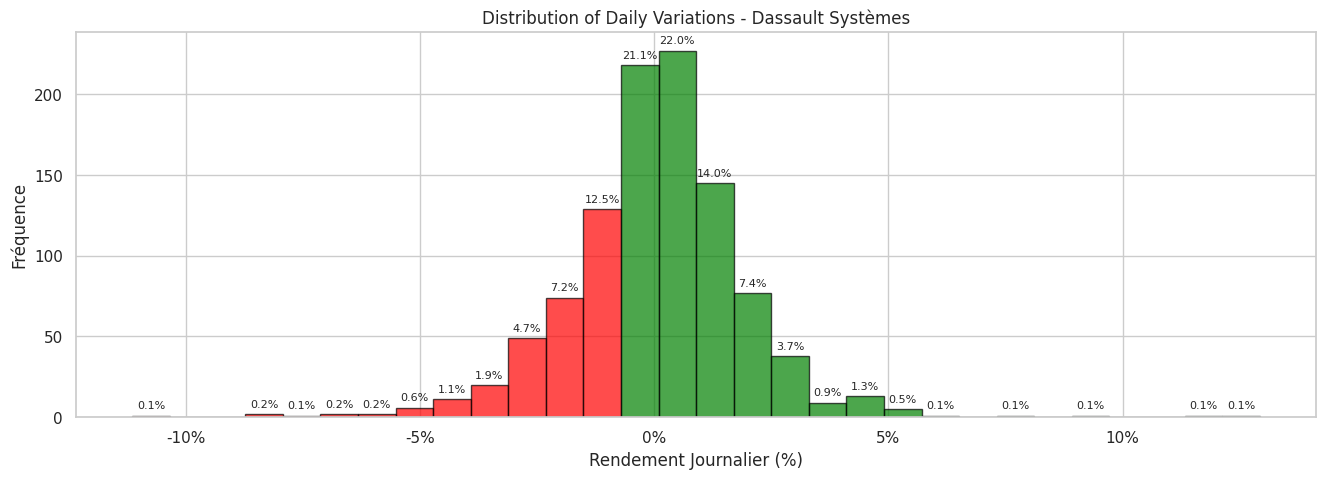

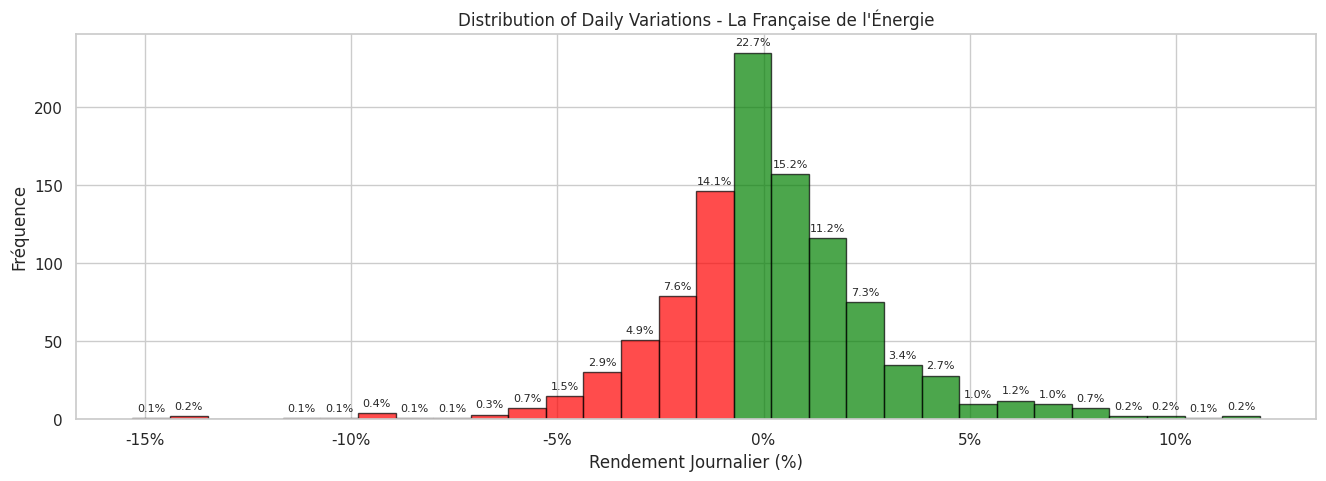

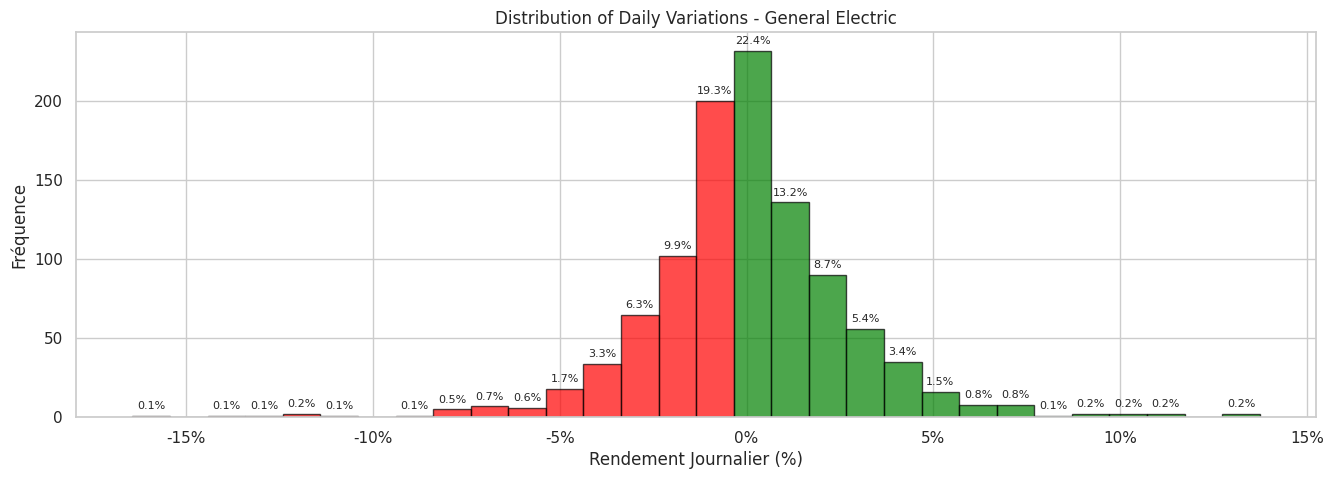

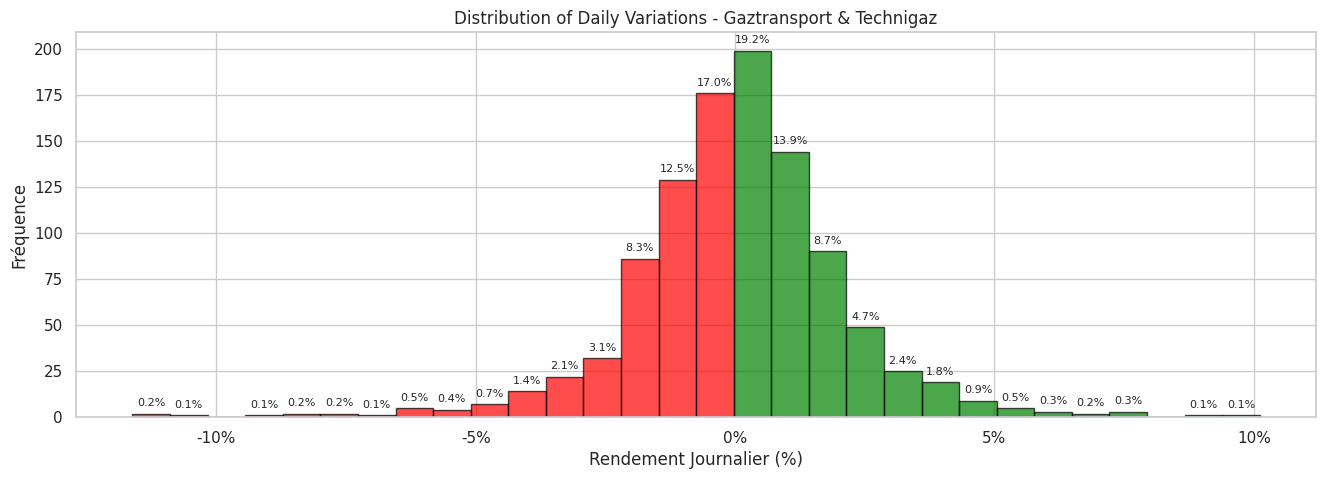

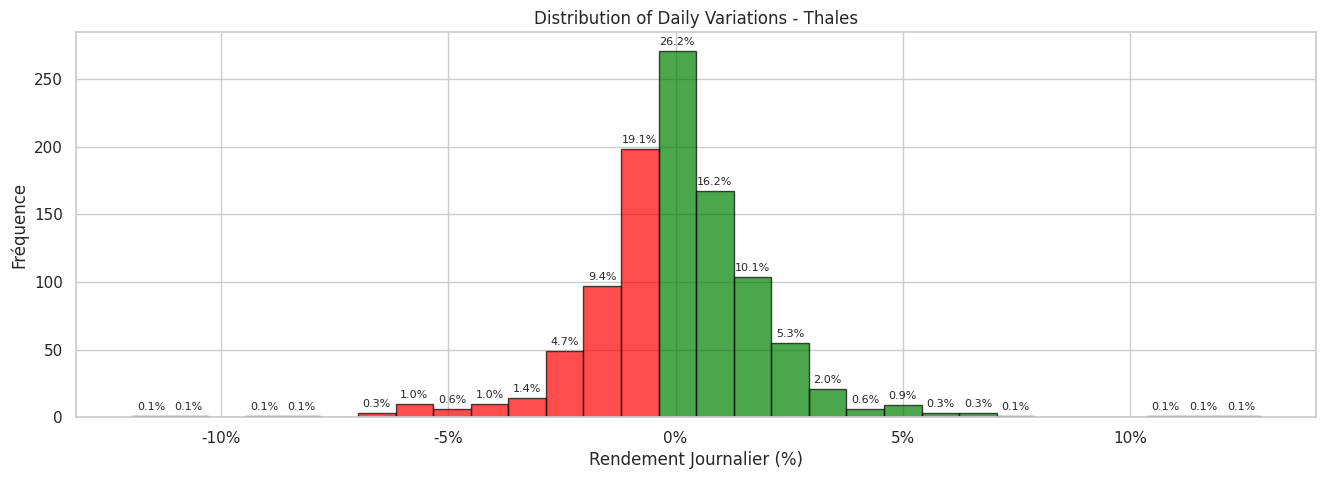

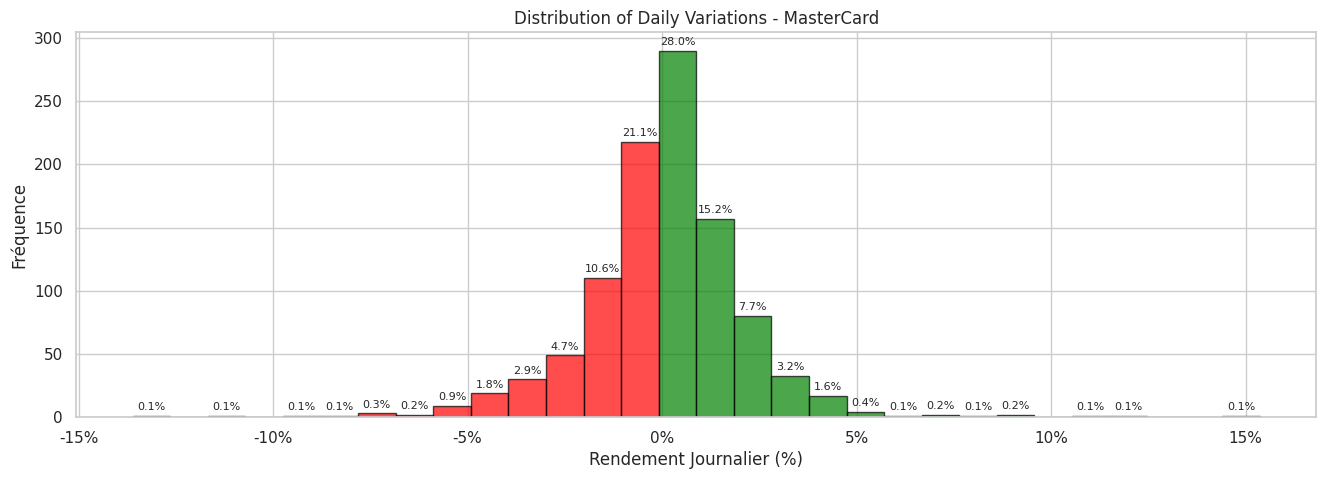

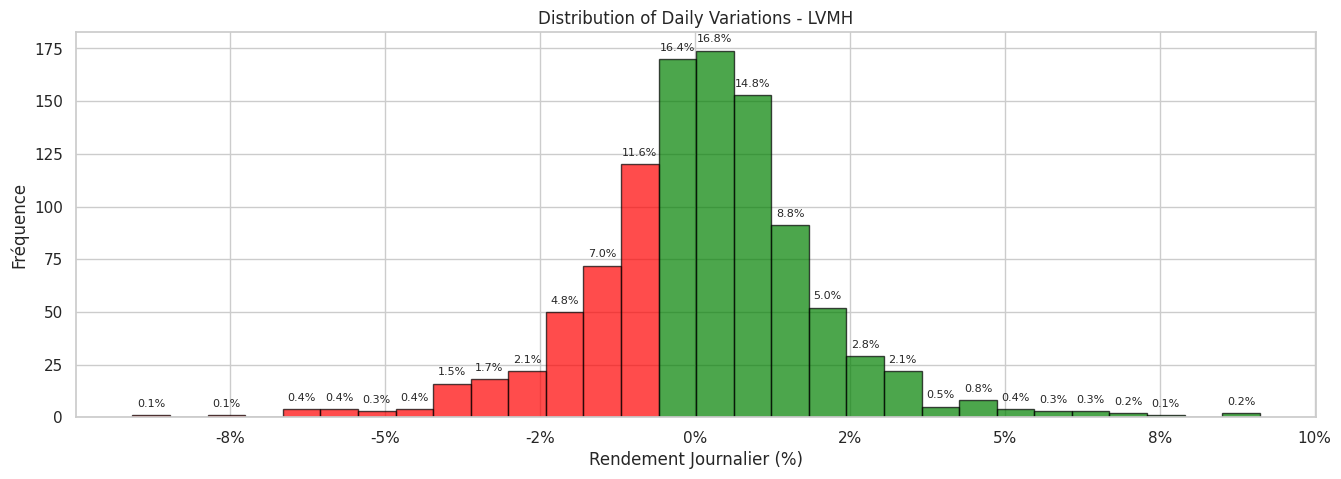

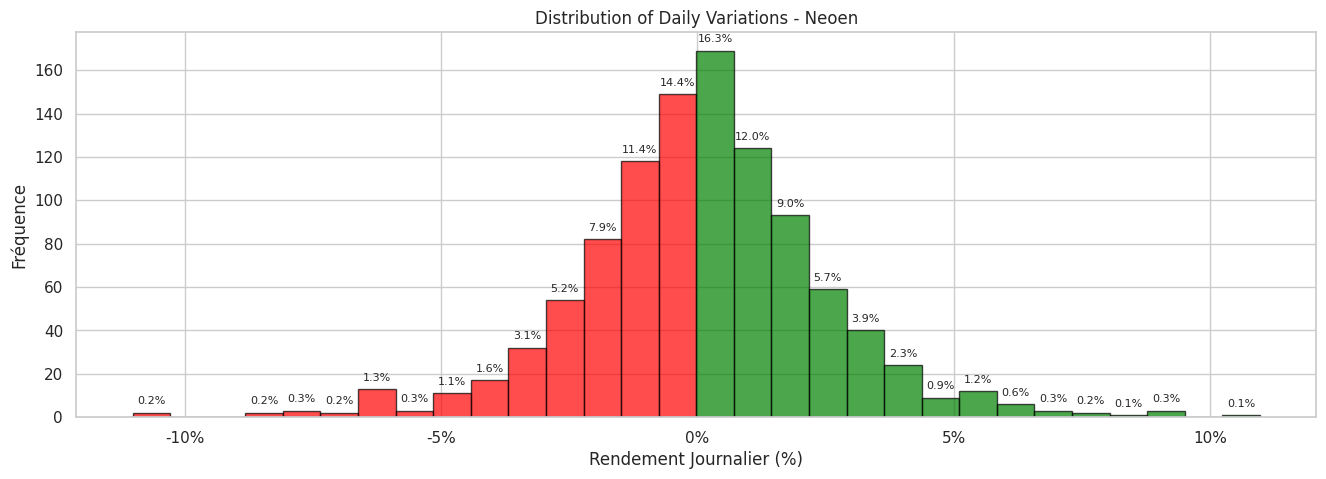

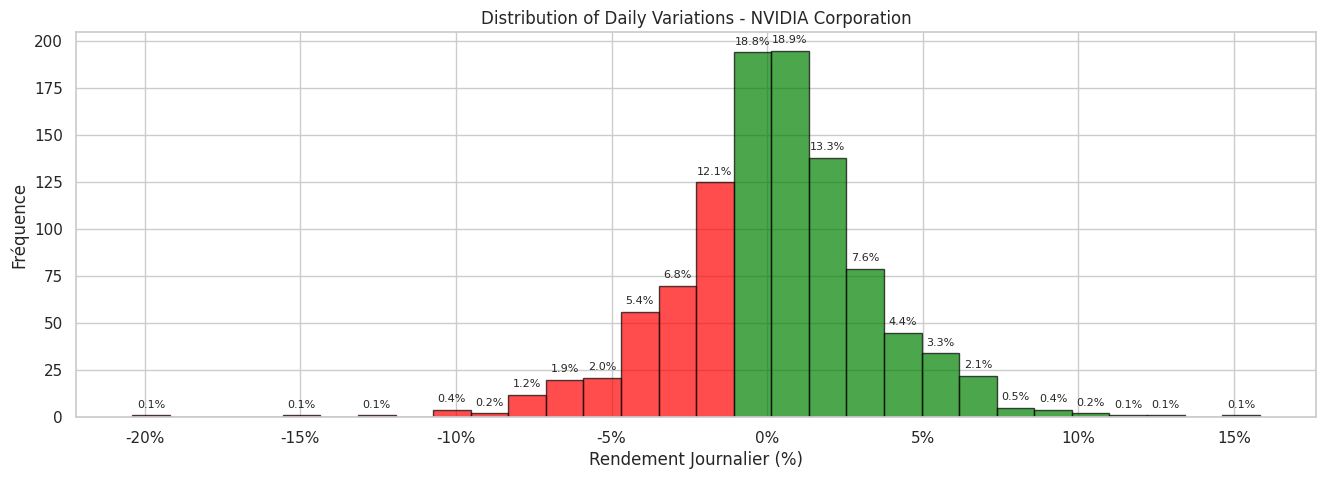

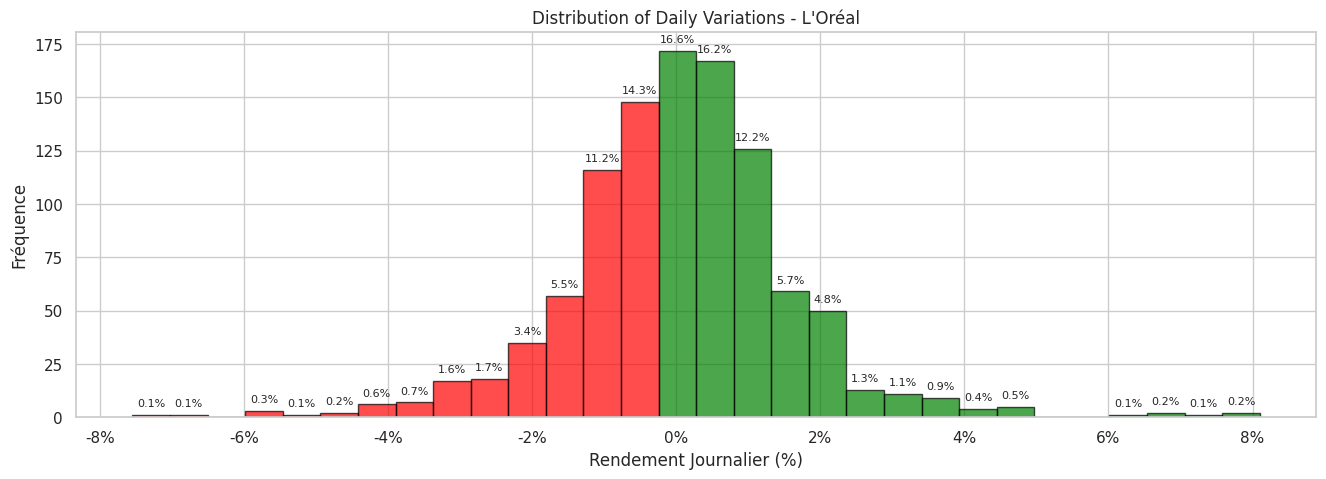

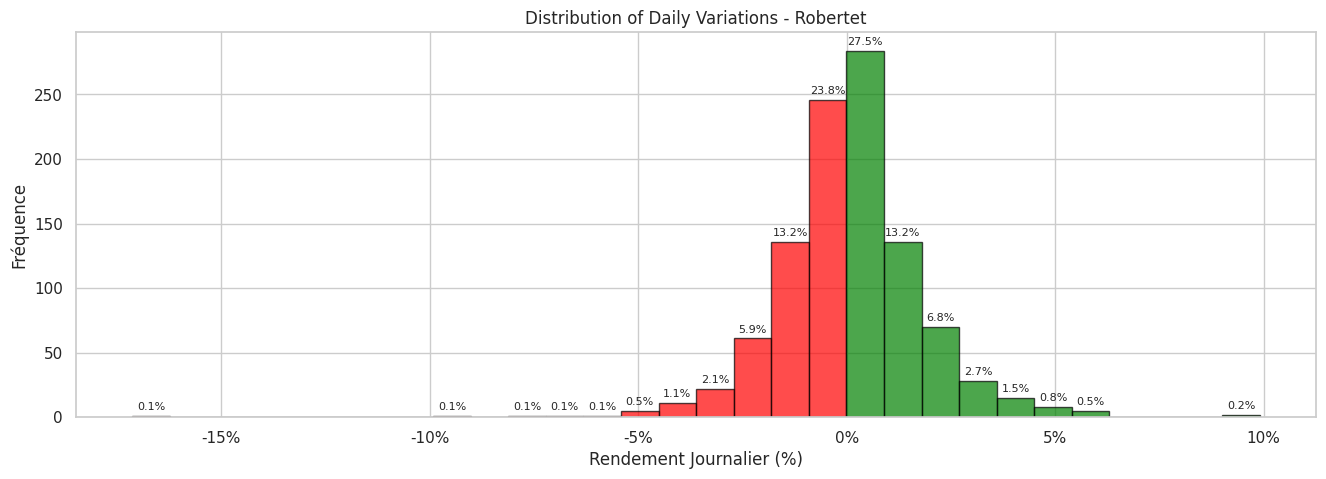

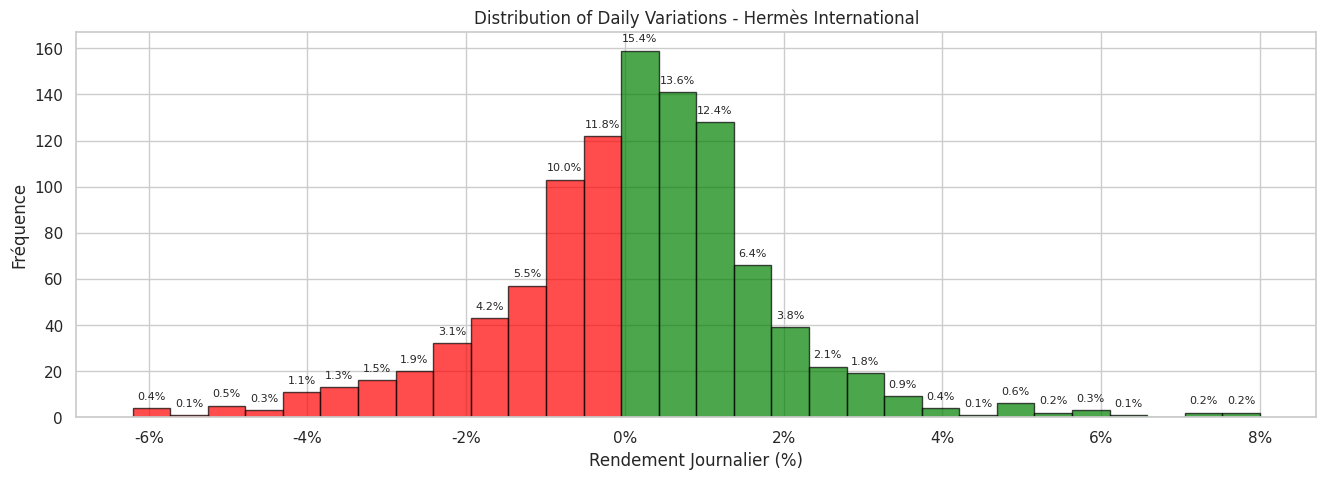

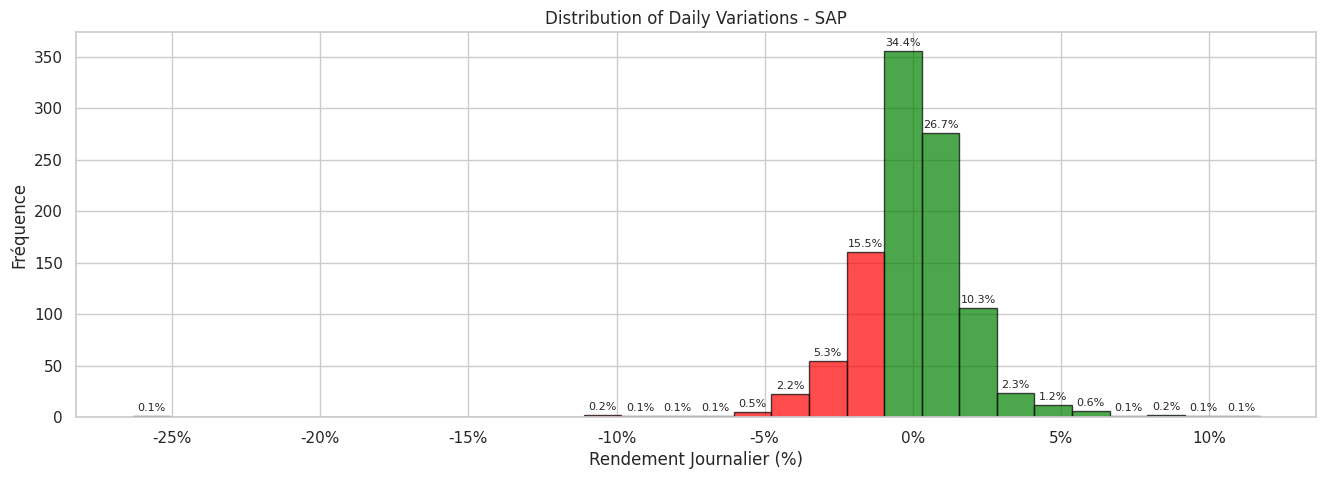

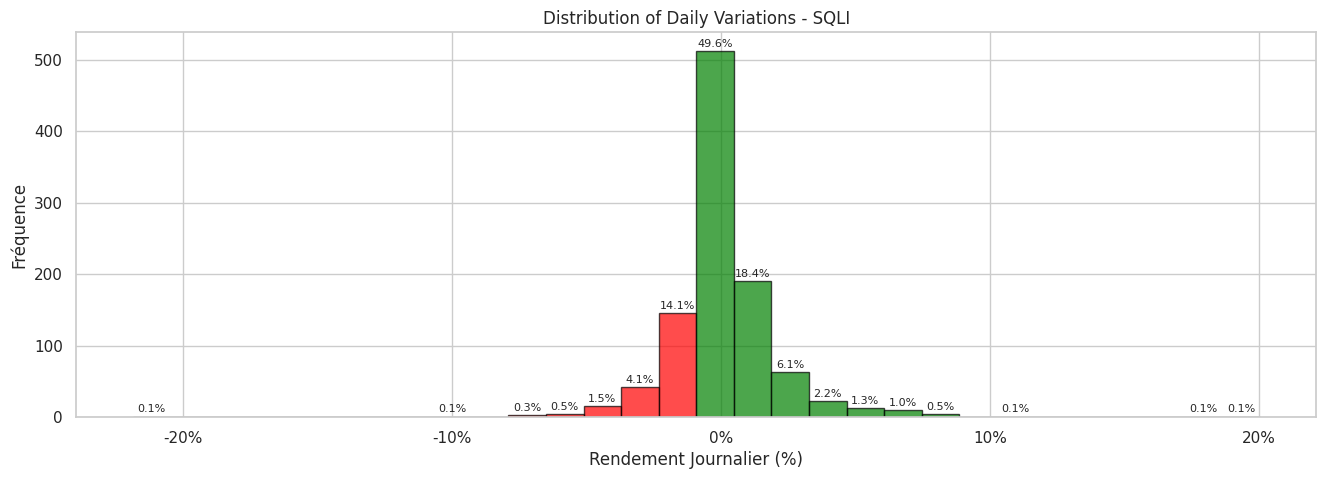

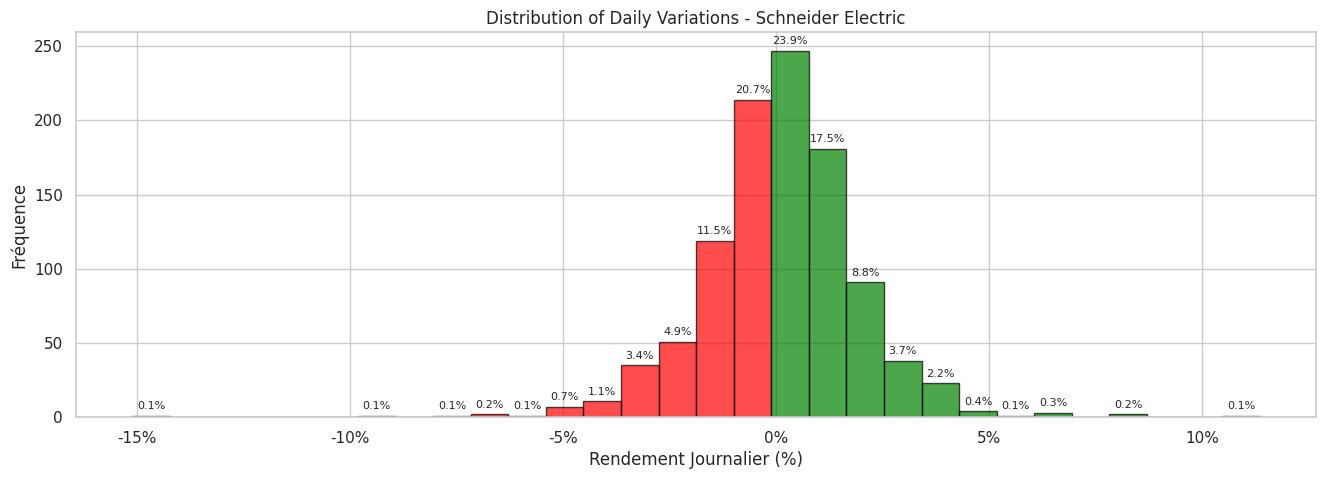

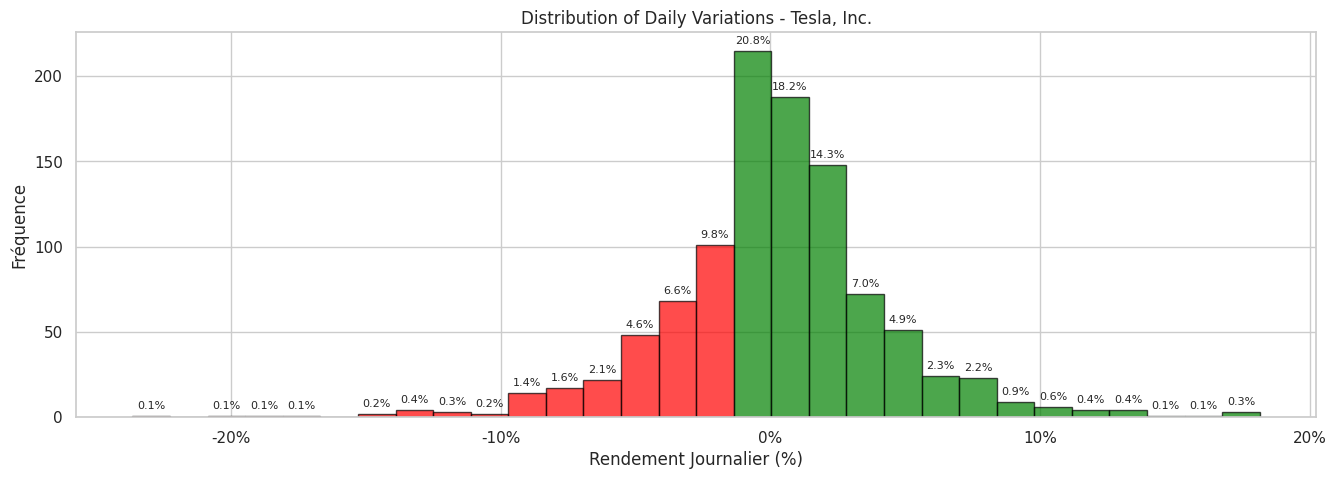

In [390]:
# DAILY RETURN DISTRIBUTION BY COMPANY FROM 2019-01-01 TO 2023-01-01

from matplotlib.ticker import FuncFormatter

# Fonction de formatage pour les pourcentages
def to_percent(y, position):
    return f"{y:.0f}%"

formatter = FuncFormatter(to_percent)

# Supposons que 'daily_returns' est un dictionnaire contenant des séries pandas de rendements journaliers pour chaque ticker.
for ticker, returns in daily_returns.items():
    plt.figure(figsize=(16, 5))
    returns_percent = returns.dropna() * 100  # Convertir en pourcentage
    n, bins, patches = plt.hist(returns_percent, bins=30, edgecolor='black', alpha=0.7)

    # Ajouter des pourcentages sur les barres
    for count, bin_edge, patch in zip(n, bins, patches):
        if count > 0:
            percentage = count / len(returns_percent) * 100
            x_pos = patch.get_x() + patch.get_width() / 2  # Centrer le texte sur la barre
            y_pos = patch.get_height()  # Positionner le texte légèrement au-dessus de la barre
            plt.text(x_pos, y_pos + 3, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)  # Ajuster si nécessaire

    # Appliquer les couleurs aux barres de l'histogramme
    # Apply colors to the histogram bars
        # Set colors based on bin values
        for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
            if right_edge < 0:
                patch.set_facecolor('red') # Negative returns
            else:
                patch.set_facecolor('green') # Positive returns

    # Récupérer le nom de la société correspondant au ticker
    company_name = tickers_to_names.get(ticker, ticker)

    plt.title(f'Distribution of Daily Variations - {company_name}')
    plt.xlabel("Rendement Journalier (%)")
    plt.ylabel("Fréquence")
    plt.gca().xaxis.set_major_formatter(formatter)  # Appliquer le formatage en pourcentage
    plt.grid(True)
    plt.show()

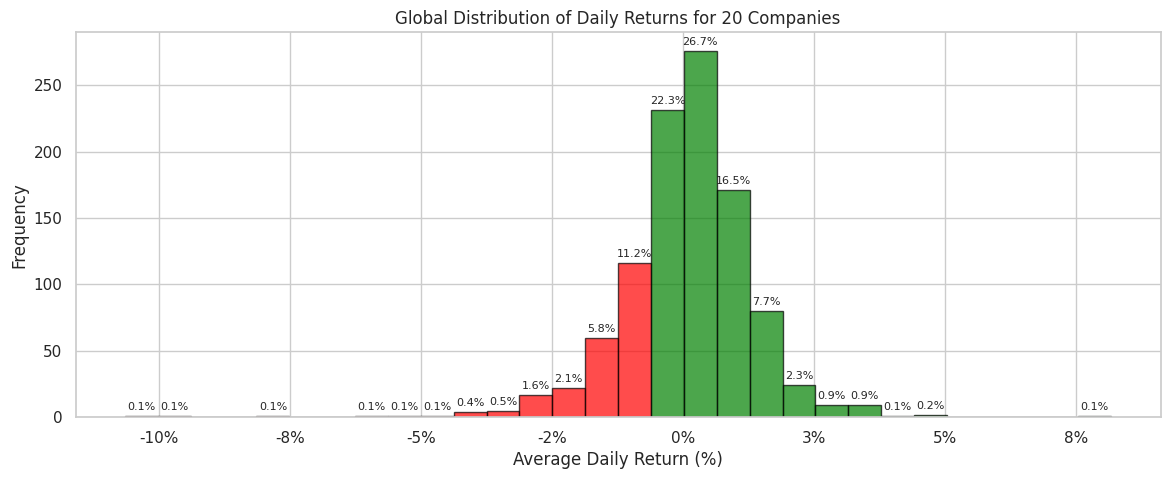

In [391]:
# AVERAGE TOTAL DAILY RETURN DISTRIBUTION FROM 2019-01-01 TO 2023-01-01

# Calculer les rendements moyens journaliers pour toutes les sociétés
mean_daily_returns = daily_returns.mean(axis=1)

plt.figure(figsize=(14, 5))

# Function for formatting percentages
def to_percent(y, position):
    return f"{100 * y:.0f}%"

formatter = FuncFormatter(to_percent)

# Plot the histogram of average daily returns
n, bins, patches = plt.hist(mean_daily_returns, bins=30, edgecolor='black', alpha=0.7)

# Add percentages on the bars
for count, bin_edge, patch in zip(n, bins[:-1], patches):
    if count > 0:
        percentage = count / len(mean_daily_returns) * 100
        # Calculate the x position to center the text on the bar
        x_pos = patch.get_x() + patch.get_width() / 2  # Centrer le texte sur la barre
        y_pos = patch.get_height()  # Positionner le texte légèrement au-dessus de la barre
        plt.text(x_pos, y_pos + 3, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

        # Apply specified colors to the bars of the histogram
        # Set colors based on bin values
        for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
            if right_edge < 0:
                patch.set_facecolor('red') # Negative returns
            else:
                patch.set_facecolor('green') # Positive returns
# Apply the formatting function to the x axis
plt.gca().xaxis.set_major_formatter(formatter)

plt.title('Global Distribution of Daily Returns for 20 Companies')
plt.xlabel('Average Daily Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

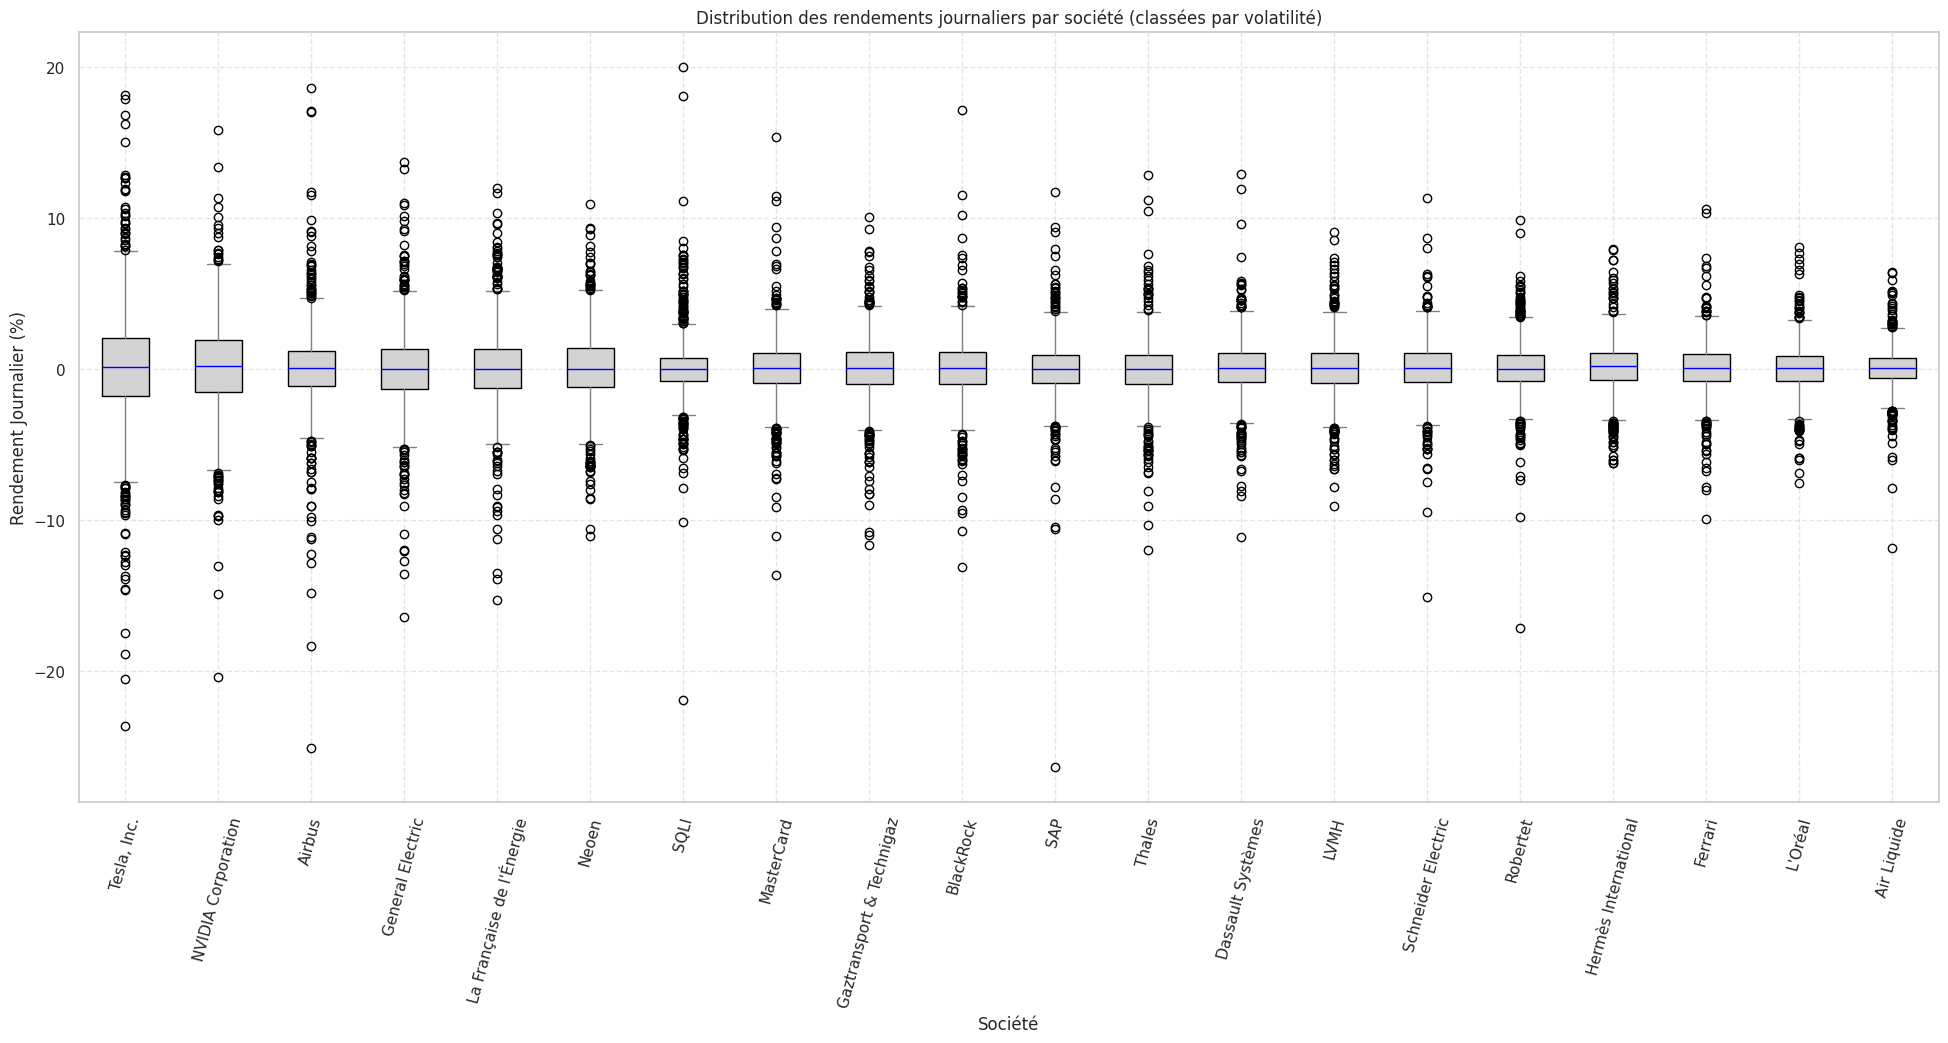

In [392]:
# GRAPH FOR DAILY RETURN FAR FROM THE AVERAGE BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Calcul de la volatilité annuelle pour chaque série de rendements (chaque colonne)
volatility = daily_returns.std() * np.sqrt(252)  # Conversion en pourcentage

# Trier les colonnes par volatilité en ordre décroissant
sorted_labels = volatility.sort_values(ascending=False).index.tolist()

# Trier les données de rendement selon l'ordre de volatilité
sorted_returns = daily_returns[sorted_labels]

# Conversion des rendements triés en pourcentage pour le graphique en boîte
sorted_returns_percent_list = [sorted_returns[col] * 100 for col in sorted_labels]

# Création d'un graphique en boîte avec les sociétés classées par volatilité
fig, ax = plt.subplots(figsize=(24, 10))
ax.boxplot(sorted_returns_percent_list, labels=sorted_labels, patch_artist=True, medianprops={'color':'blue'}, boxprops={'color':'black', 'facecolor':'lightgrey'}, whiskerprops={'color':'grey'}, capprops={'color':'grey'})

ax.set_title('Distribution des rendements journaliers par société (classées par volatilité)')
ax.set_xlabel('Société')
ax.set_ylabel('Rendement Journalier (%)')
ax.tick_params(axis='x', rotation=75)
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

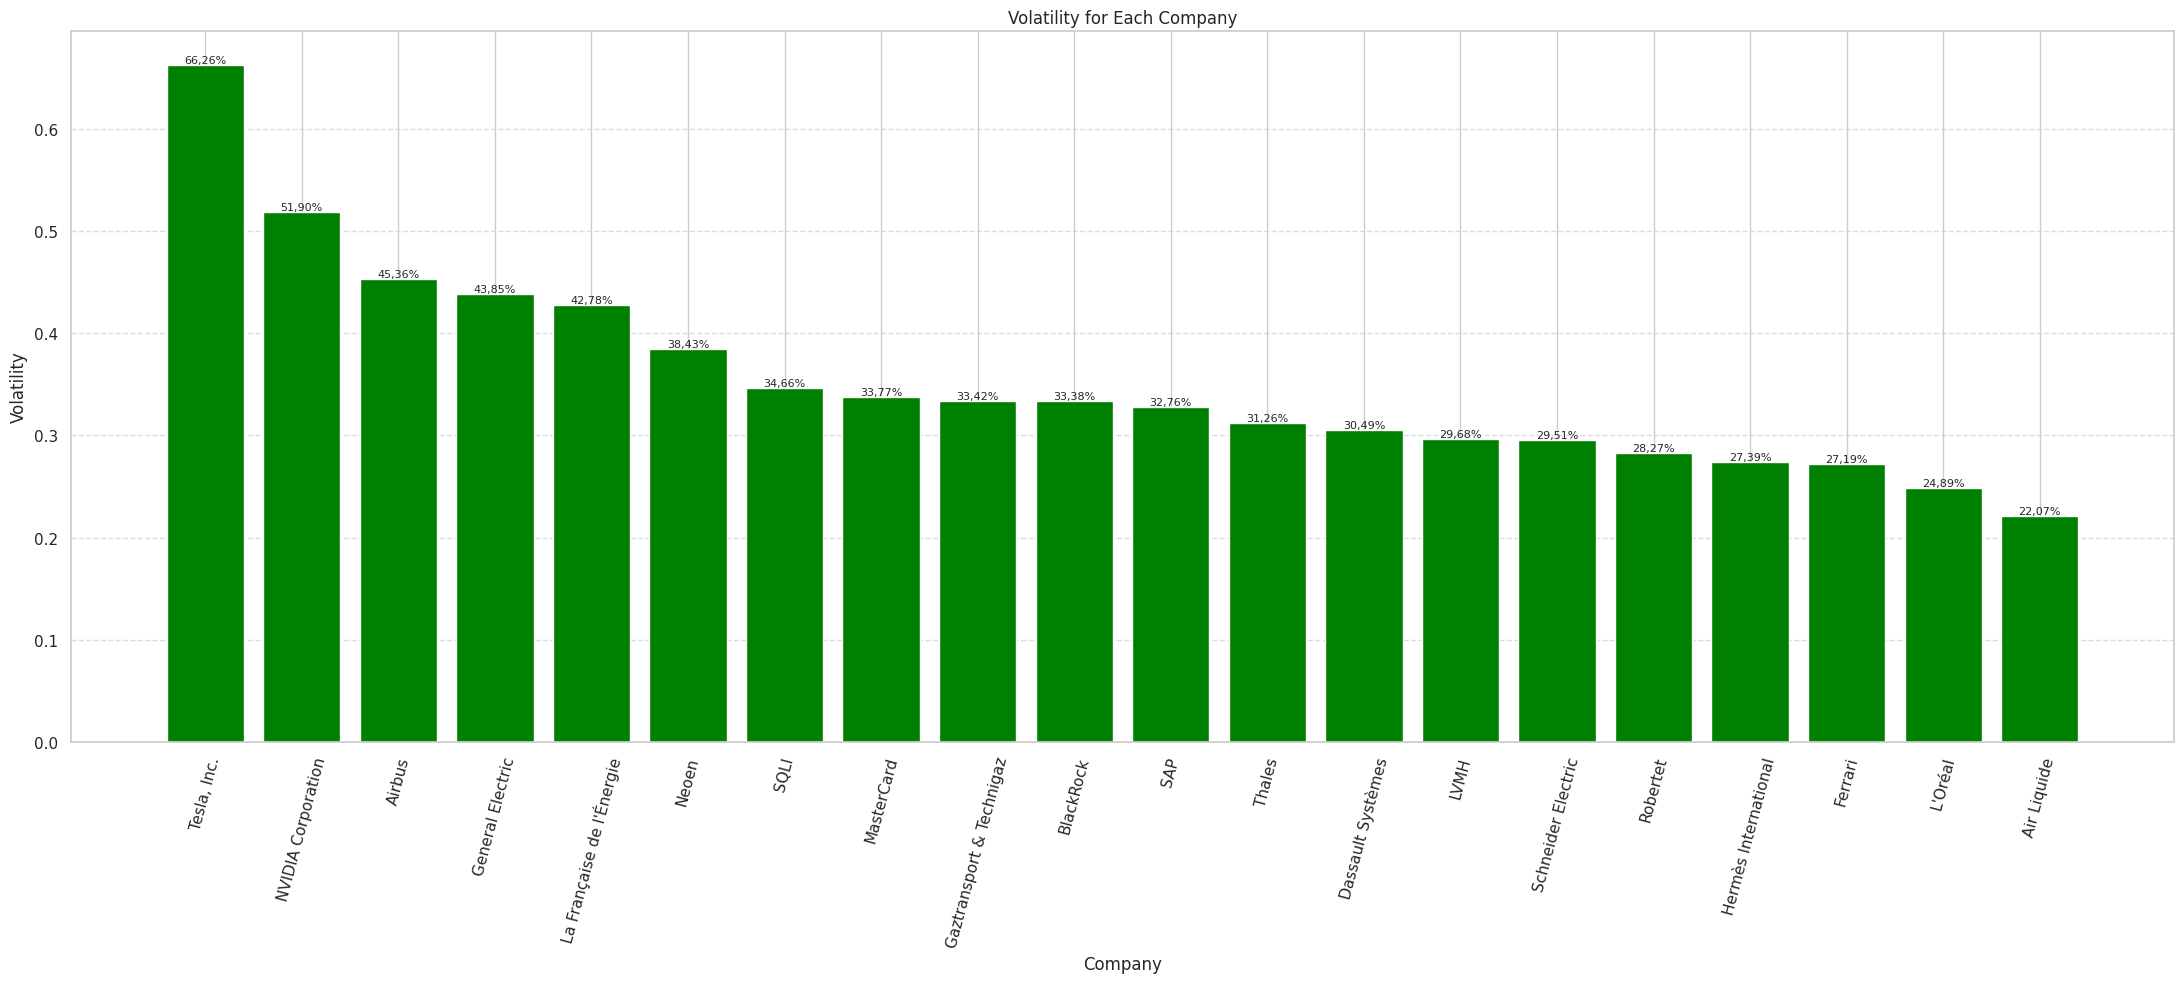

In [393]:
# HISTORICAL ANNUALIZED VOLATILITY BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Calcul des rendements quotidiens pour chaque ticker
daily_returns = np.log(data_filled / data_filled.shift(1))

# Calculate the annualized volatility for each ticker
volatility = daily_returns.std() * np.sqrt(252)

# Sort volatility values in descending order
sorted_volatility = volatility.sort_values(ascending=False)

# Replace ticker symbols with company names for plotting, providing the ticker itself as a fallback
sorted_volatility.index = [tickers_to_names.get(ticker, ticker) for ticker in sorted_volatility.index]

# Define colors
colors = ['green'] * len(sorted_volatility)  # Ensure the colors list matches the number of bars

# Plot the volatility bar chart without using the 'plot' method to avoid color conflict
plt.figure(figsize=(22, 10))
bars = plt.bar(sorted_volatility.index, sorted_volatility, color=colors)
plt.title('Volatility for Each Company')
plt.xlabel('Company')
plt.ylabel('Volatility')
plt.xticks(rotation=75)  # Rotate the company names for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar (formatted as percentages with two decimal places and a comma as the decimal separator)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval*100:.2f}'.replace('.', ',') + '%',
             va='bottom', ha='center', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()

In [394]:
# VOLATILITY OF THIS PORTFOLIO IN COMPARISON TO BENCHMARK FROM 2019-01-01 TO 2023-01-01

# Calculer les rendements quotidiens des données filtrées
returns_filtered = data_filled.pct_change().dropna()

# Calcul de la matrice de covariance des rendements filtrés
cov_matrix_returns = returns_filtered.cov()

# Définir les pondérations du portefeuille, supposons une pondération égale pour la simplicité
weights = np.array([1/returns_filtered.shape[1]] * returns_filtered.shape[1])

# Calcul de la volatilité du portefeuille
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_returns, weights))) * np.sqrt(252)

# Création d'un DataFrame pour stocker la volatilité annuelle de chaque indice et du portefeuille
volatility_table = pd.DataFrame(columns=['Entity', 'Annual Volatility'])

# Ajout de la volatilité du portefeuille au DataFrame
volatility_table.loc[len(volatility_table)] = {'Entity': 'Portefeuille', 'Annual Volatility': portfolio_volatility * 100}

# Liste des indices avec leurs symboles Yahoo Finance
indices = {
    'CAC 40': '^FCHI',
    'S&P 500': '^GSPC',
    'Euro Stoxx 50': '^STOXX50E',
    'BlackRock US Growth': '0P00000AWD',
    'NASDAQ Composite': '^IXIC',
    'DAX': '^GDAXI',
    'MSCI World': 'URTH',
    'Amundi MSCI Europe Growth': 'CG9.PA'
}

# Création d'un DataFrame pour stocker la volatilité annuelle de chaque indice et du portefeuille
# (réinitialisation du DataFrame pour éviter les duplications)
volatility_table = pd.DataFrame(columns=['Entity', 'Annual Volatility'])

for name, symbol in indices.items():
    data = yf.download(symbol, start='2019-01-01', end='2023-01-01', progress=False)['Adj Close'].dropna()
    daily_returns = data.pct_change().dropna()
    annual_volatility = np.sqrt(daily_returns.var() * 252) * 100

    # Créer un DataFrame pour la nouvelle ligne et utiliser pd.concat pour l'ajouter
    new_row = pd.DataFrame({'Entity': [name], 'Annual Volatility': [annual_volatility]})
    volatility_table = pd.concat([volatility_table, new_row], ignore_index=True)

# Après la boucle, pour ajouter la volatilité du portefeuille sans utiliser `append`:
new_row = pd.DataFrame({'Entity': ['Portefeuille'], 'Annual Volatility': [portfolio_volatility * 100]})
volatility_table = pd.concat([volatility_table, new_row], ignore_index=True)

# Trier le tableau par volatilité annuelle
volatility_table_sorted = volatility_table.sort_values(by='Annual Volatility', ascending=False)

# Formatons la colonne de volatilité pour afficher 2 décimales et le symbole %
volatility_table_sorted['Annual Volatility'] = volatility_table_sorted['Annual Volatility'].apply(lambda x: f"{x:.2f}%")

# Affichage du tableau trié avec tabulate
print(tabulate(volatility_table_sorted, headers='keys', tablefmt='pretty', showindex=False))

+---------------------------+-------------------+
|          Entity           | Annual Volatility |
+---------------------------+-------------------+
|    BlackRock US Growth    |      36.58%       |
|     NASDAQ Composite      |      26.74%       |
|          S&P 500          |      22.92%       |
|            DAX            |      22.54%       |
|       Euro Stoxx 50       |      22.30%       |
|          CAC 40           |      21.86%       |
|        MSCI World         |      21.84%       |
|       Portefeuille        |      20.52%       |
| Amundi MSCI Europe Growth |      18.58%       |
+---------------------------+-------------------+


[*********************100%%**********************]  20 of 20 completed


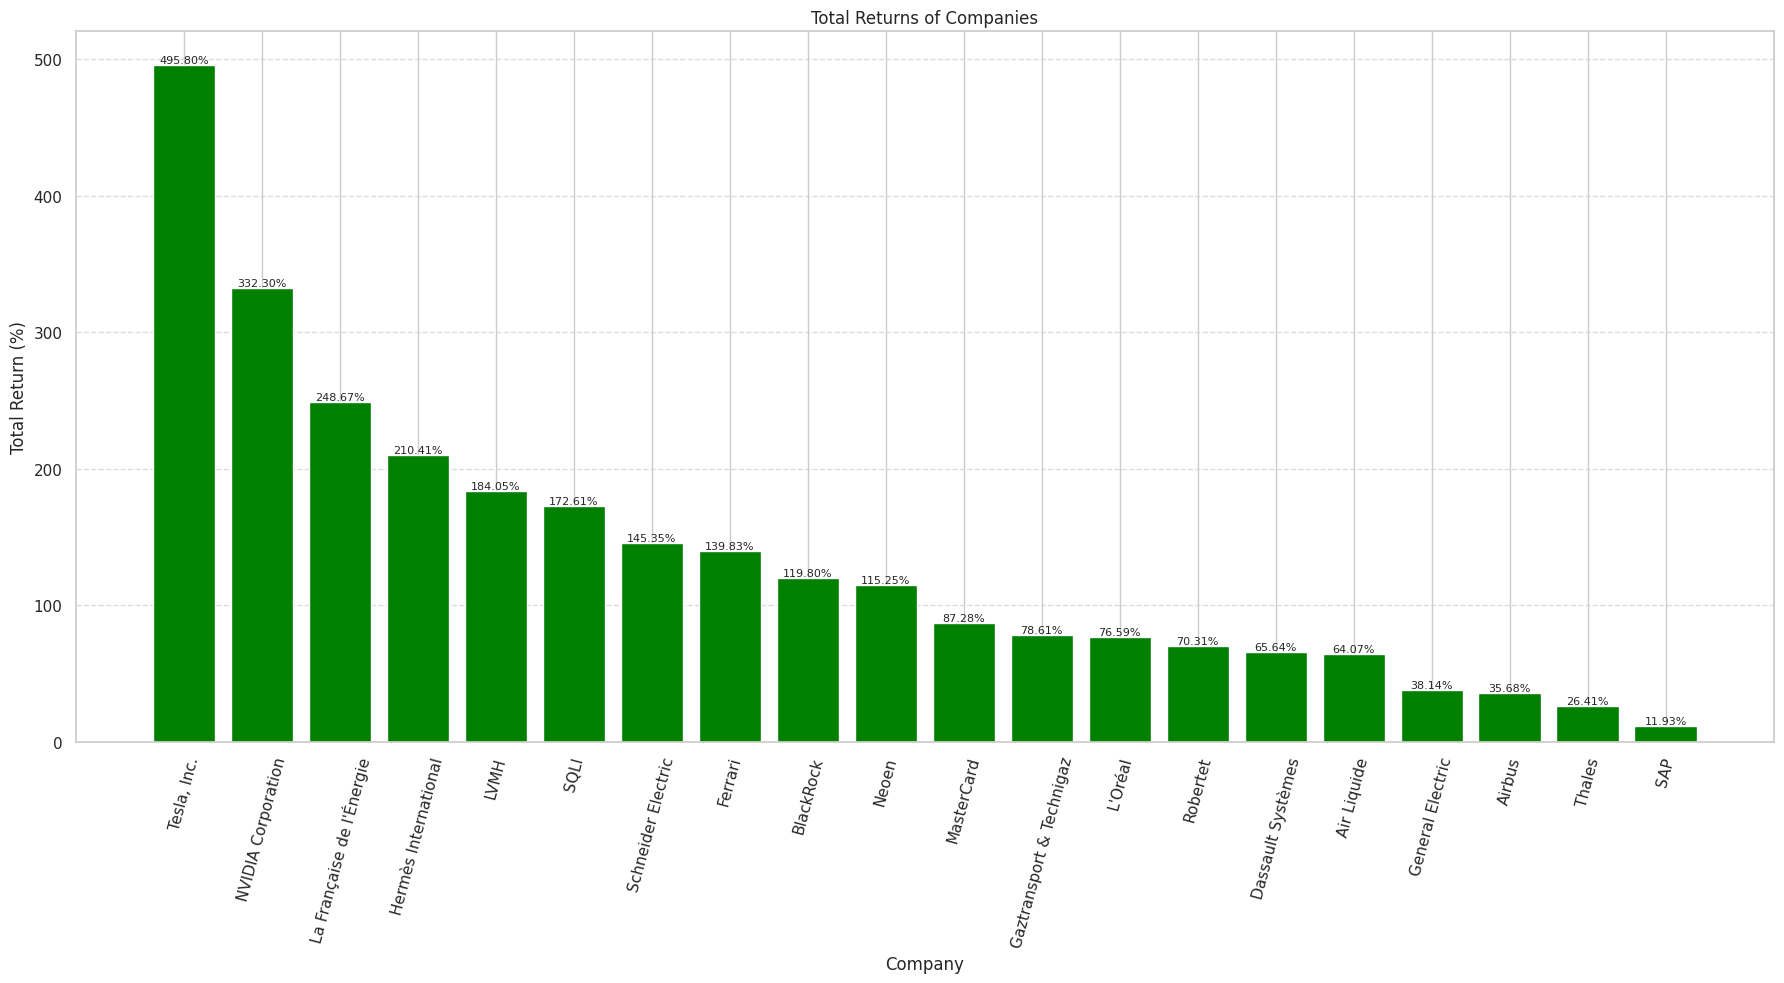

In [395]:
# TOTAL RETURN BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Téléchargement des données
tickers = list(tickers_to_names.keys())
data = yf.download(tickers, start="2019-01-01", end="2023-01-01")['Adj Close']
data_filled = data.fillna(method='ffill')

start_date = data.index.min()
end_date = data.index.max()

# Fonction pour calculer le rendement total sur la période
def calculate_total_return(data, ticker):
    first_valid_price = data[ticker].first_valid_index()
    last_valid_price = data[ticker].last_valid_index()
    total_return = (data[ticker].loc[last_valid_price] - data[ticker].loc[first_valid_price]) / data[ticker].loc[first_valid_price] * 100
    return total_return

# Calculer les rendements totaux sur la période pour chaque actif
total_returns = {tickers_to_names[ticker]: calculate_total_return(data_filled, ticker) for ticker in tickers}

# Créer un DataFrame pour les rendements totaux
total_returns_df = pd.DataFrame(list(total_returns.items()), columns=['Company', 'Total Return'])
total_returns_df.sort_values(by='Total Return', ascending=False, inplace=True)

# Création du graphique à barres
bar_colors = ['green' if x >= 0 else 'red' for x in total_returns_df['Total Return']]
plt.figure(figsize=(18, 10))
bars = plt.bar(total_returns_df['Company'], total_returns_df['Total Return'], color=bar_colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom' if yval >= 0 else 'top', fontsize=8)  # Taille de police réduite

plt.title('Total Returns of Companies')
plt.xlabel('Company')
plt.ylabel('Total Return (%)')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

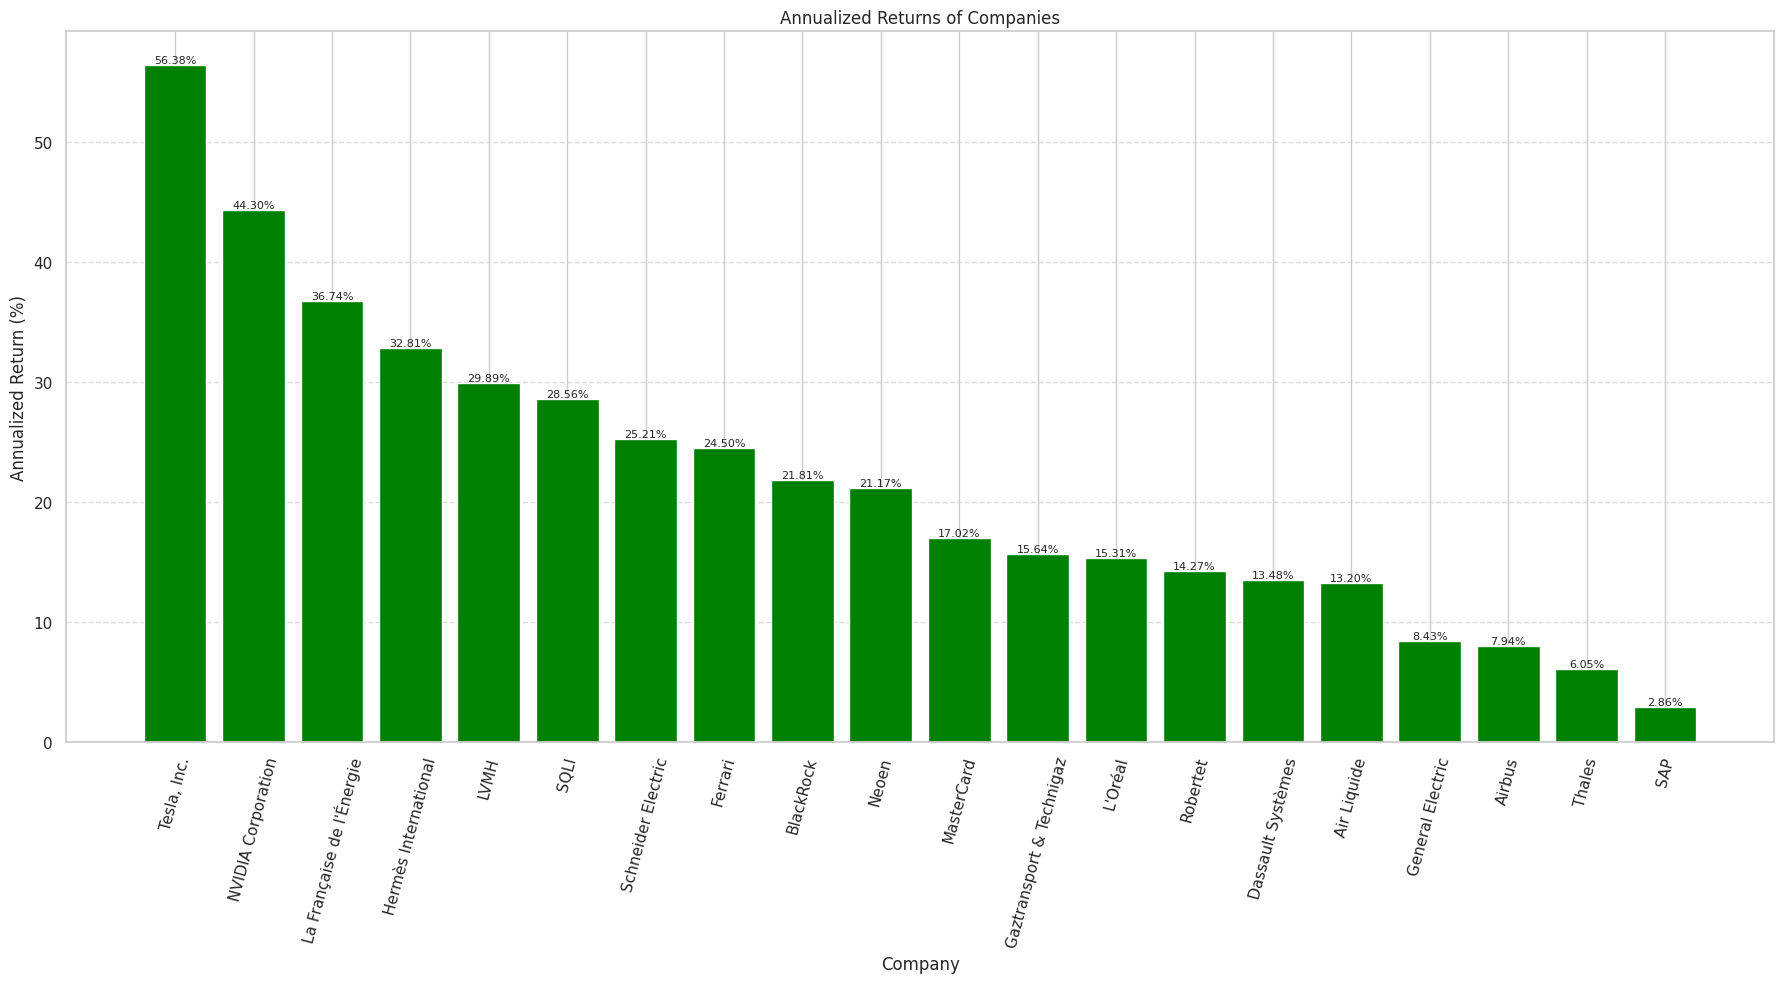

In [396]:
# TOTAL ANNUALIZED RETURN BY COMPANY FROM 2019-01-01 TO 2023-01-01

# Fonction pour calculer le rendement le plus proche
def calculate_nearest_return(data, ticker):
    first_valid_price = data[ticker].first_valid_index()
    last_valid_price = data[ticker].last_valid_index()
    return_value = (data[ticker].loc[last_valid_price] - data[ticker].loc[first_valid_price]) / data[ticker].loc[first_valid_price] * 100
    return return_value

# Fonction pour calculer le rendement annualisé
def calculate_annualized_return(total_return, start_date, end_date):
    period_years = (end_date - start_date).days / 365.25
    annualized_return = ((1 + total_return / 100) ** (1 / period_years) - 1) * 100
    return annualized_return

# Calculer les rendements et les rendements annualisés
returns = {tickers_to_names[ticker]: calculate_nearest_return(data_filled, ticker) for ticker in tickers}
annualized_returns = {company: calculate_annualized_return(return_value, start_date, end_date) for company, return_value in returns.items()}

# Créer un DataFrame pour les rendements annualisés
annualized_returns_df = pd.DataFrame(list(annualized_returns.items()), columns=['Company', 'Annualized Return'])
annualized_returns_df.sort_values(by='Annualized Return', ascending=False, inplace=True)

# Création du graphique à barres avec une taille de police réduite pour les pourcentages
bar_colors = ['green' if x >= 0 else 'red' for x in annualized_returns_df['Annualized Return']]
plt.figure(figsize=(18, 10))
bars = plt.bar(annualized_returns_df['Company'], annualized_returns_df['Annualized Return'], color=bar_colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom' if yval >= 0 else 'top', fontsize=8)  # Taille de police réduite

plt.title('Annualized Returns of Companies')
plt.xlabel('Company')
plt.ylabel('Annualized Return (%)')
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

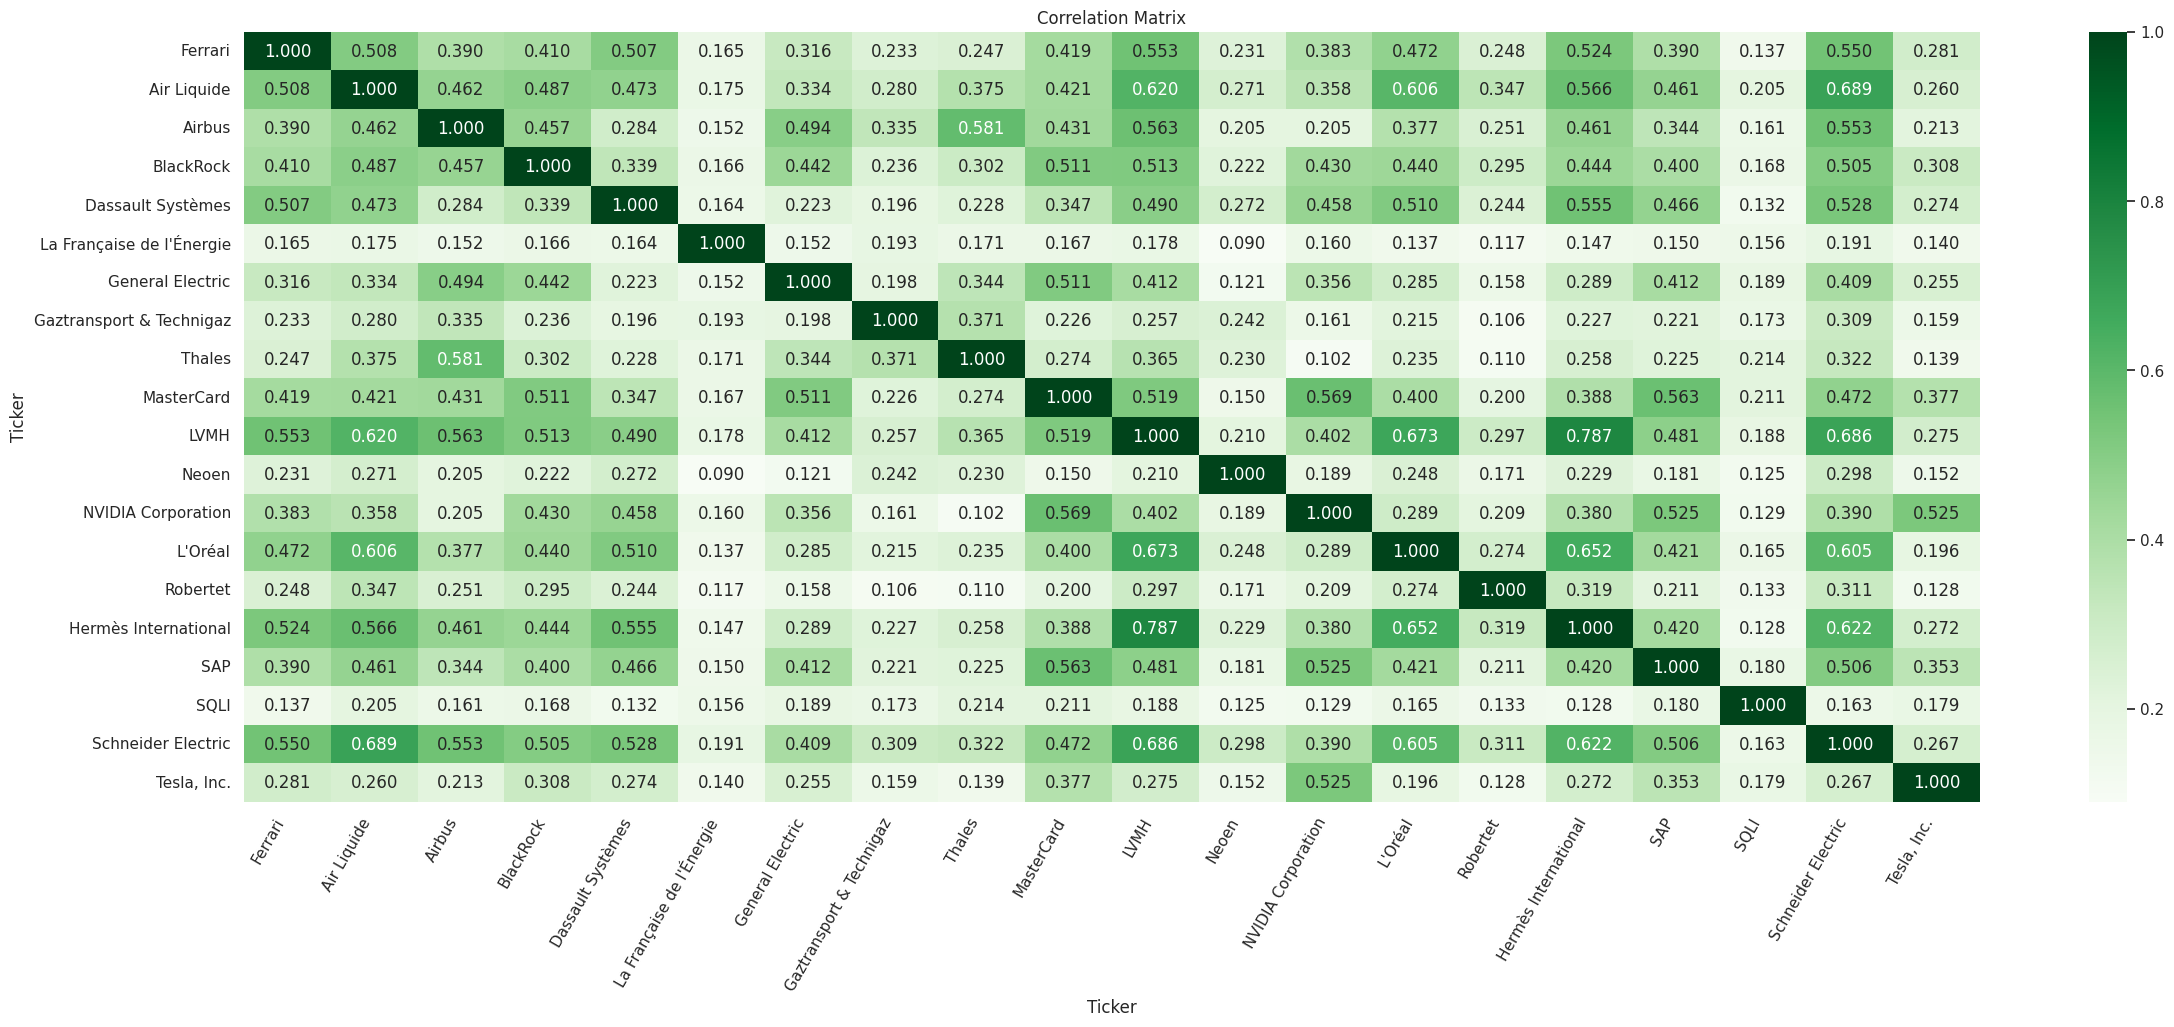

In [397]:
# CORRELATION MATRIX BETWEEN COMPANY FROM 2019-01-01 TO 2023-01-01

daily_returns = np.log(data_filled / data_filled.shift(1))

company_labels = [tickers_to_names[ticker] for ticker in daily_returns.columns]

# Calculez la matrice de corrélation
correlation = daily_returns.corr()

# Configurez le style seaborn
sns.set(style="whitegrid")

# Tracer la matrice de corrélation avec une carte de couleurs verte
plt.figure(figsize=(28, 10))
plt.title('Correlation Matrix')
corr_plot = sns.heatmap(correlation, annot=True, fmt=".3f", cmap='Greens', xticklabels=company_labels, yticklabels=company_labels)
plt.xticks(rotation=60, ha='right')
plt.yticks(rotation=0)
plt.show()

In [398]:
# SECOND PART : PORTFOLIO ALLOCATION AT JANUARY 3, 2023
# SIMULATION OF A PORTFOLIO

num_stocks = len(tickers)

# Générer des valeurs aléatoires qui somment à 1
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
weights = np.round(weights * 100, decimals=3)  # Convertir en pourcentage et arrondir à 3 décimales

# Convertir chaque poids en une chaîne formatée avec un symbole de pourcentage
weights_str = [f"{weight:.3f}%" for weight in weights]

print('Weights (%):', weights_str)
print('Total Weight (%):', f"{np.sum(weights):.3f}%")

Weights (%): ['5.429%', '8.867%', '7.538%', '10.090%', '1.765%', '8.951%', '4.253%', '0.628%', '10.819%', '2.294%', '2.269%', '1.822%', '7.089%', '0.025%', '0.256%', '3.091%', '6.330%', '5.622%', '7.749%', '5.112%']
Total Weight (%): 99.999%


In [399]:
# ANNUALIZED RETURN SIMULATION

# Calcul du rendement quotidien moyen du portefeuille, annualisé
portfolio_return = np.sum(weights * daily_returns.mean()) * 252

# Convertir le rendement en pourcentage et formater avec trois décimales
portfolio_return_percentage = f"{portfolio_return :.3f}%"

print("Rendement annuel du portefeuille :", portfolio_return_percentage)

# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * daily_returns.mean()) * 252

Rendement annuel du portefeuille : 18.862%


18.862083239501025

In [400]:
# VOLATILITY SIMULATION

# Calculez la volatilité du portefeuille, annualisée
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

# Formatez la volatilité du portefeuille en pourcentage avec trois décimales
portfolio_volatility_percentage = f"{portfolio_volatility:.3f}%"

print("Volatilité annuelle du portefeuille :", portfolio_volatility_percentage)

np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

Volatilité annuelle du portefeuille : 21.898%


21.897818147008838

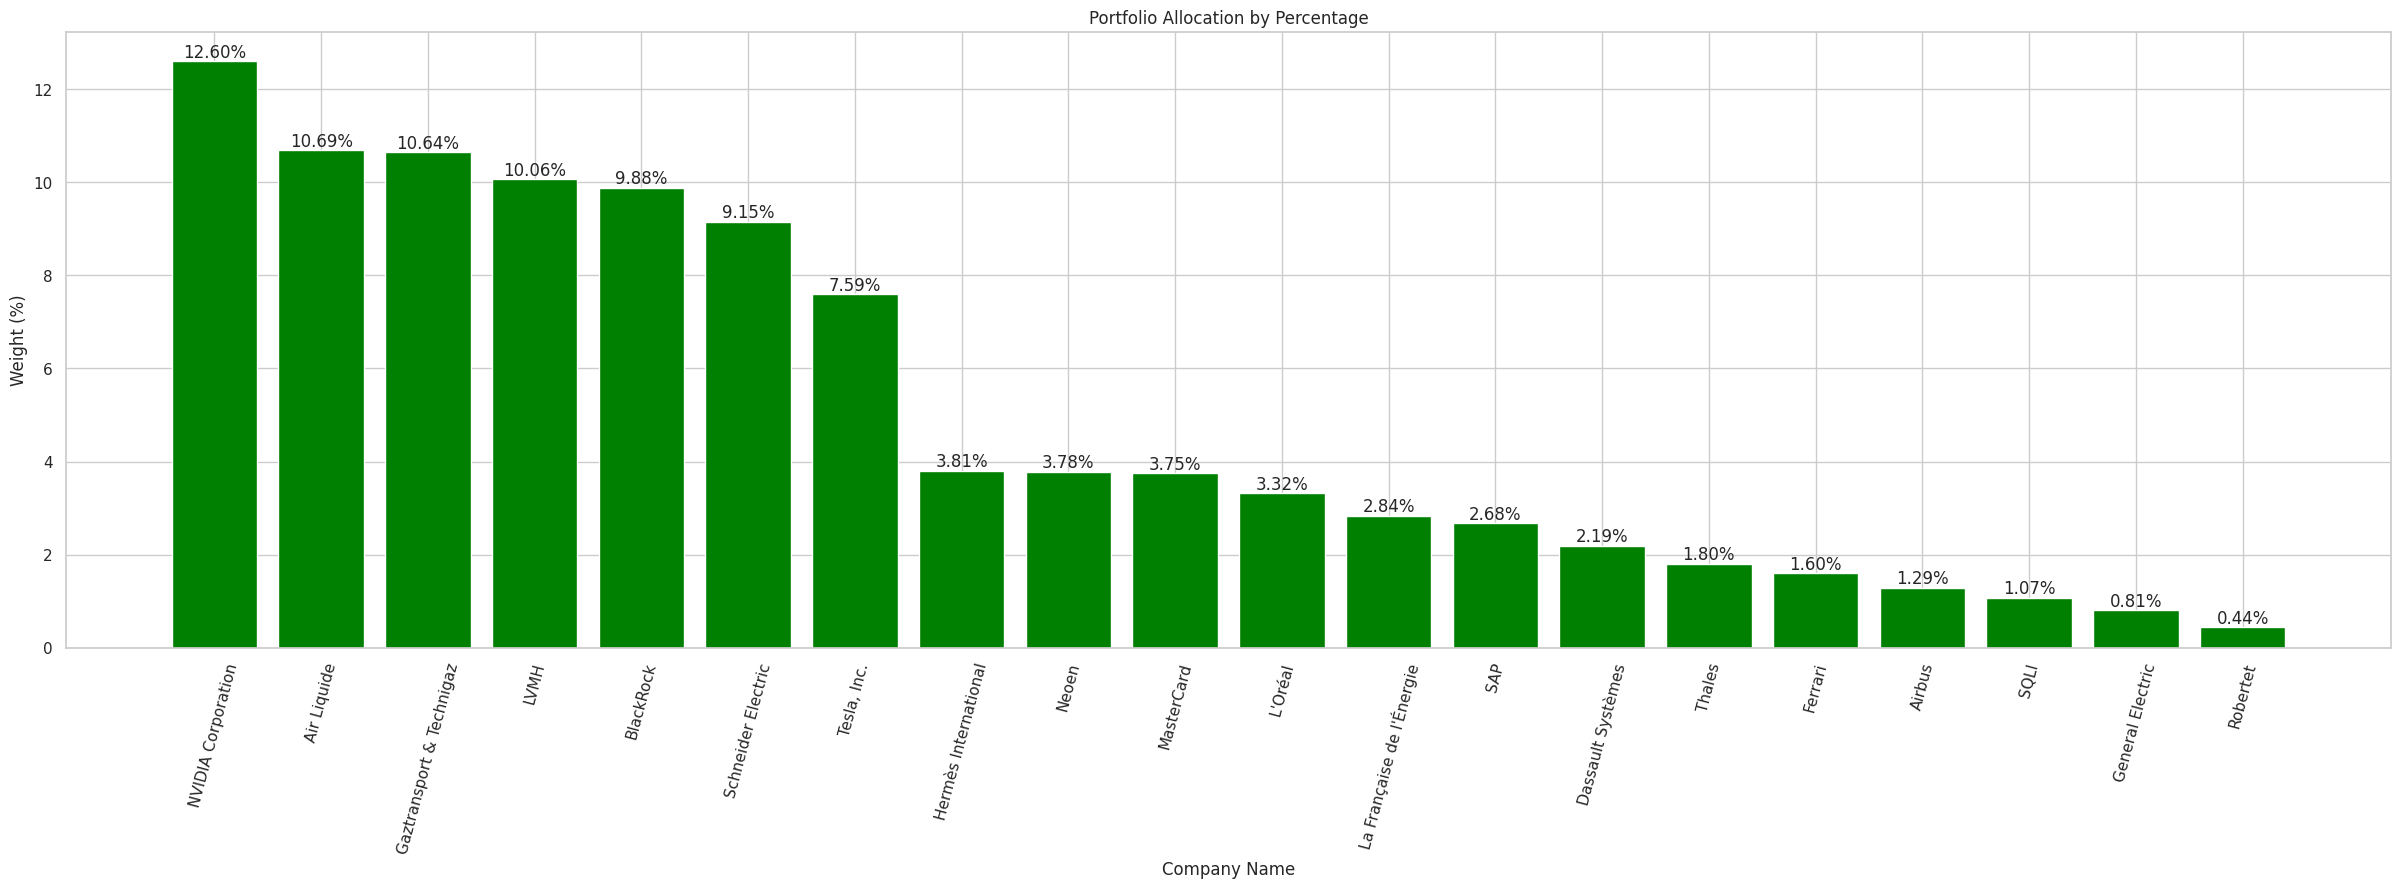

In [401]:
# OPTIMAL PORTFOLIO SIMULATION

p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list

for x in range(1000):
    # Generate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)

    # Add return using those weights to list
    ret_1 = np.sum(p_weights * daily_returns.mean()) * 252
    p_ret.append(ret_1)

    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(daily_returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)

    # Get Sharpe ratio
    risk_free_rate = 0.0325
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)

    # Store the weights for each portfolio
    p_wt.append(p_weights)

# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

# Tri des poids dans l'ordre décroissant pour le graphique
SR_idx = np.argmax(p_SR)
optimal_weights_MC = p_wt[SR_idx]
sorted_indices = np.argsort(optimal_weights_MC)[::-1]
sorted_tickers = np.array(tickers)[sorted_indices]
sorted_weights = optimal_weights_MC[sorted_indices]

# Création du graphique avec des barres colorées et des pourcentages au-dessus
plt.figure(figsize=(30, 8))
sorted_names = [tickers_to_names[ticker] for ticker in sorted_tickers]
bars = plt.bar(sorted_names, sorted_weights * 100, color='green')  # Multiplier par 100 pour obtenir des pourcentages

# Ajouter des étiquettes de pourcentage au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Portfolio Allocation by Percentage')
plt.xlabel('Company Name')
plt.ylabel('Weight (%)')
plt.xticks(rotation=75)  # Rotation pour une meilleure lisibilité
plt.show()

In [402]:
#TOTAL ALLOCATION: 25% from optimal portfolio, 37.5% from equal shares, 37.5% from degressive amount depending on market cap

In [403]:
# ALLOCATION BY COMPANY FROM THIS OPTIMAL PORTFOLIO SIMULATION

montant_total = 1000000

# Calcul du montant total investi, qui est 25% de l'allocation totale
montant_total_investi = 0.25 * montant_total

# Calcul des montants investis dans chaque société
montants_investis_MC = sorted_weights * montant_total_investi

# Création du DataFrame pour les montants investis dans chaque société
investissements_df = pd.DataFrame({
    'Société': sorted_names,
    'Montant Investi (€)': [f'{montant:.2f}€' for montant in montants_investis_MC],
    'Pourcentage de l\'allocation': [f'{pct:.2f}%' for pct in sorted_weights * 100]  # Ajout de la colonne des pourcentages
})

# Calcul du total des montants investis
total_montants_investis = sum(montants_investis_MC)
investissements_df.loc[len(investissements_df)] = ['Total', f"{total_montants_investis:.2f}€", '']

# Affichage du DataFrame sous forme de tabulate
tabulate_df = tabulate(investissements_df, headers='keys', tablefmt='grid')
print(tabulate_df)

+----+---------------------------+-----------------------+-------------------------------+
|    | Société                   | Montant Investi (€)   | Pourcentage de l'allocation   |
+====+===========================+=======================+===============================+
|  0 | NVIDIA Corporation        | 31497.32€             | 12.60%                        |
+----+---------------------------+-----------------------+-------------------------------+
|  1 | Air Liquide               | 26717.32€             | 10.69%                        |
+----+---------------------------+-----------------------+-------------------------------+
|  2 | Gaztransport & Technigaz  | 26607.44€             | 10.64%                        |
+----+---------------------------+-----------------------+-------------------------------+
|  3 | LVMH                      | 25156.50€             | 10.06%                        |
+----+---------------------------+-----------------------+-------------------------------+

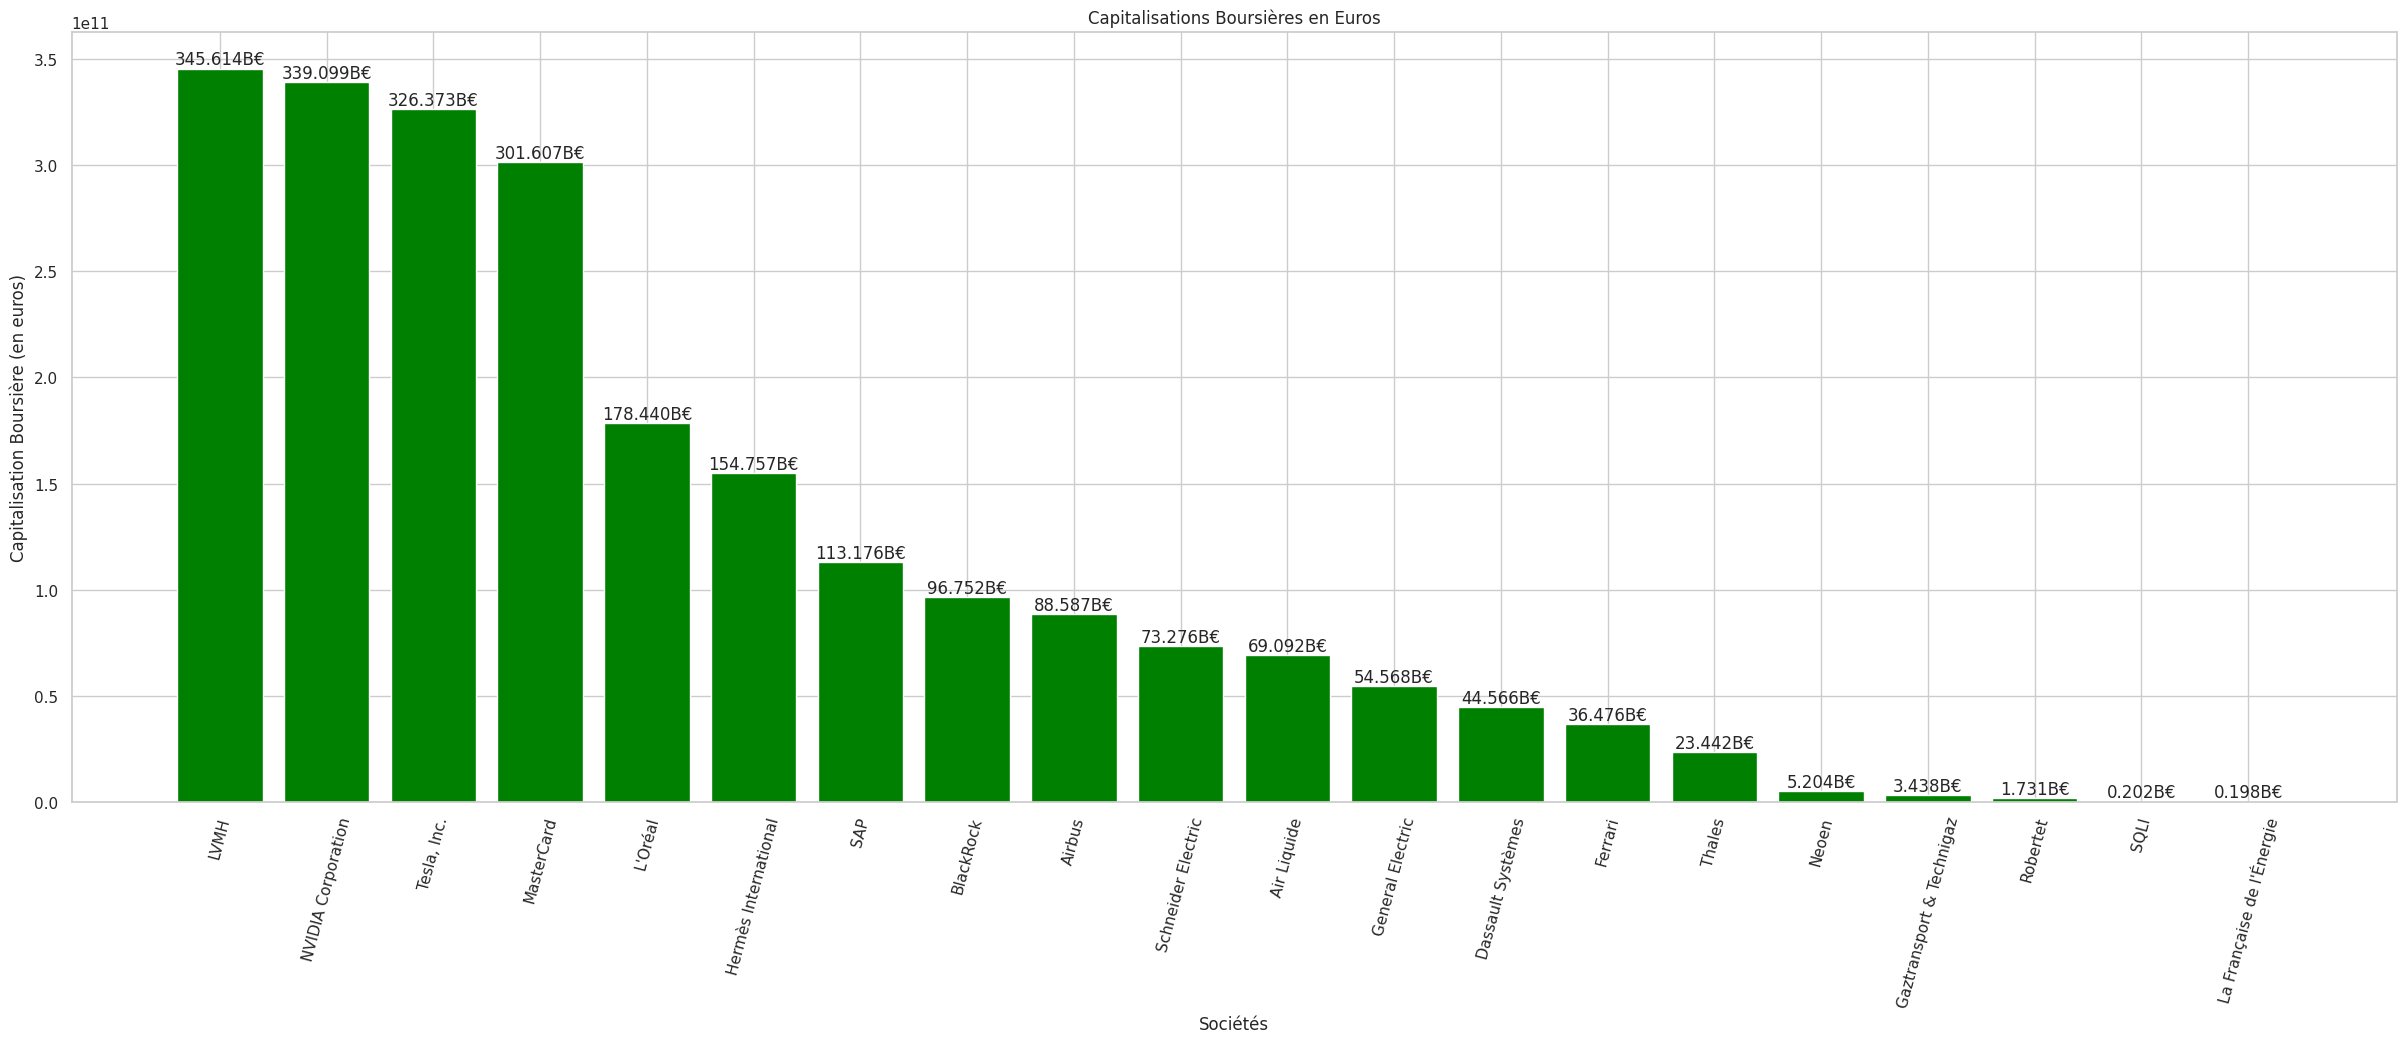

In [404]:
# MARKET CAP BY COMPANY IN EURO

# Hypothétique dictionnaire des taux de change vers l'euro, par exemple :
taux_de_change = {"USD": 0.9480, "EUR": 1}  # Assurez-vous d'avoir le taux de change correct pour chaque devise

market_caps_eur = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    try:
        historical_data = stock.history(start="2023-01-03", end="2023-01-04")
        market_cap = historical_data['Close'][0] * stock.info['sharesOutstanding']
        # Obtenir la devise de la société et convertir la market cap en euros
        devise = stock.info['currency']
        taux = taux_de_change.get(devise, 1)  # Utiliser 1 comme fallback si la devise n'est pas trouvée
        market_cap_eur = market_cap * taux
        # Utiliser le nom de la société au lieu du ticker
        company_name = tickers_to_names.get(ticker, "Unknown")  # Fallback sur "Unknown" si non trouvé
        market_caps_eur[company_name] = market_cap_eur
    except Exception as e:
        print(f"Erreur lors de la récupération des informations pour {ticker}: {e}")

# Trier les capitalisations boursières du plus grand au plus petit, converties en euros
sorted_market_caps_eur = dict(sorted(market_caps_eur.items(), key=lambda item: item[1], reverse=True))

# Création du graphique avec des barres, affichage en euros
plt.figure(figsize=(30, 10))
bars = plt.bar(sorted_market_caps_eur.keys(), sorted_market_caps_eur.values(), color='green')

# Ajouter les valeurs (en milliards d'euros) au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/1e9:.3f}B€', ha='center', va='bottom')

plt.title('Capitalisations Boursières en Euros')
plt.xlabel('Sociétés')
plt.ylabel('Capitalisation Boursière (en euros)')
plt.xticks(rotation=75)  # Ajustez selon besoin pour la lisibilité
plt.show()

In [405]:
# ALLOCATION BY COMPANY FROM DEGRESSIVE MARKET CAP

# Nombre total de sociétés
num_companies = len(sorted_market_caps_eur)

# Allocation de 8% à 2% en fonction de la capitalisation boursière
allocations = np.linspace(0.08, 0.02, num_companies)

# Répartir les allocations en fonction des capitalisations boursières
allocated_amounts = {company: montant_total * alloc * 0.375 for company, alloc in zip(sorted_market_caps_eur.keys(), allocations)}

# Convertir en DataFrame pour un affichage tabulé
allocations_df = pd.DataFrame({
    "Société": list(allocated_amounts.keys()),
    "Allocation (%)": [f"{alloc * 100:.2f}%" for alloc in allocations],
    "Montant à Investir (€)": [f"{montant:.2f}€" for montant in allocated_amounts.values()]
})

# Ajout du total du montant investi
total_invested_amount = sum(allocated_amounts.values())
allocations_df.loc[len(allocations_df)] = ['Total', '', f"{total_invested_amount:.2f}€"]

# Affichage du DataFrame sous forme de tabulate
tabulate_df = tabulate(allocations_df, headers='keys', tablefmt='grid', showindex=False)
print(tabulate_df)

+---------------------------+------------------+--------------------------+
| Société                   | Allocation (%)   | Montant à Investir (€)   |
+===========================+==================+==========================+
| LVMH                      | 8.00%            | 30000.00€                |
+---------------------------+------------------+--------------------------+
| NVIDIA Corporation        | 7.68%            | 28815.79€                |
+---------------------------+------------------+--------------------------+
| Tesla, Inc.               | 7.37%            | 27631.58€                |
+---------------------------+------------------+--------------------------+
| MasterCard                | 7.05%            | 26447.37€                |
+---------------------------+------------------+--------------------------+
| L'Oréal                   | 6.74%            | 25263.16€                |
+---------------------------+------------------+--------------------------+
| Hermès Int

In [406]:
# ALLOCATION BY COMPANY FROM EQUAL SHARES

# Calcul de la part égale investie dans chaque société
montants_parts_egales = montant_total * 0.375 / len(sorted_names)

# Calcul du pourcentage de la part égale par rapport au montant total investi
pourcentage_part_egale = (montant_total / 20) / 10000

# Création du DataFrame pour la part égale investie dans chaque société
part_egale_df = pd.DataFrame({
    'Société': sorted_names,
    'Montant Investi (€)': [f'{montants_parts_egales:.2f}€' for _ in range(len(sorted_names))],
    'Pourcentage de la part égale': [f'{pourcentage_part_egale:.2f}%' for _ in range(len(sorted_names))]
})

# Calcul du montant total investi pour la part égale dans chaque société
montant_total_part_egale = len(sorted_names) * montants_parts_egales

# Création du DataFrame avec la somme des montants investis pour chaque société
part_egale_df['Montant Investi (€)'] = [f'{montants_parts_egales:.2f}€' for _ in range(len(sorted_names))]
part_egale_df.loc[len(part_egale_df)] = ['Total', f'{montant_total_part_egale:.2f}€', '']

# Affichage du DataFrame sous forme de tabulate
tabulate_df = tabulate(part_egale_df, headers='keys', tablefmt='grid')
print(tabulate_df)

+----+---------------------------+-----------------------+--------------------------------+
|    | Société                   | Montant Investi (€)   | Pourcentage de la part égale   |
+====+===========================+=======================+================================+
|  0 | NVIDIA Corporation        | 18750.00€             | 5.00%                          |
+----+---------------------------+-----------------------+--------------------------------+
|  1 | Air Liquide               | 18750.00€             | 5.00%                          |
+----+---------------------------+-----------------------+--------------------------------+
|  2 | Gaztransport & Technigaz  | 18750.00€             | 5.00%                          |
+----+---------------------------+-----------------------+--------------------------------+
|  3 | LVMH                      | 18750.00€             | 5.00%                          |
+----+---------------------------+-----------------------+----------------------

[*********************100%%**********************]  20 of 20 completed


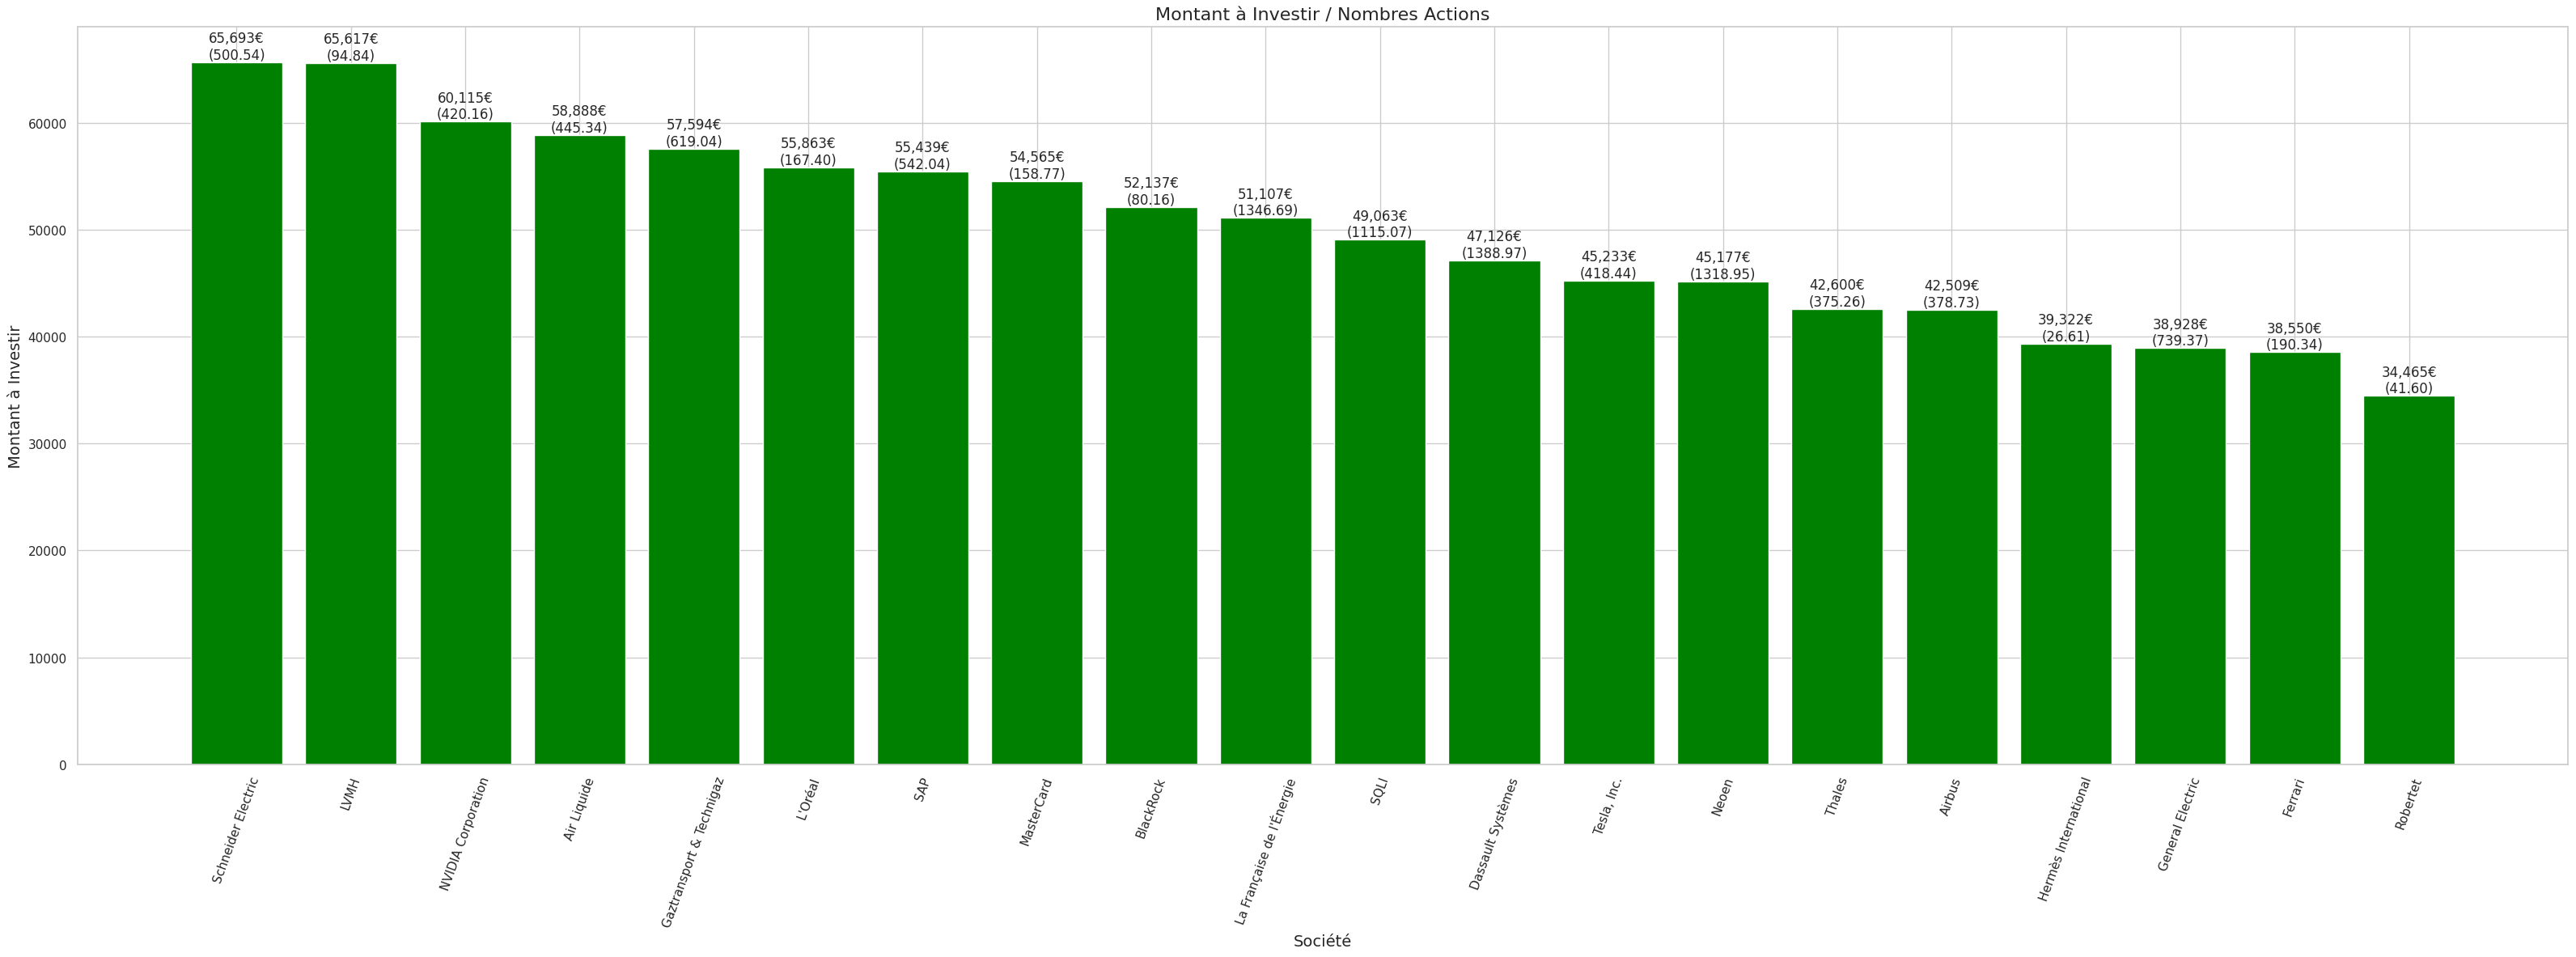


Montant investis : 1,000,000.00€


In [421]:
# FINAL ALLOCATION FOR MY PORTFOLIO BY COMPANY

# Les pourcentages d'allocation pour chaque stratégie
pourcentage_MC = 0.25
pourcentage_parts_egales = 0.375
pourcentage_degressif = 0.375

# Télécharger les données des prix des actions
data = yf.download(tickers, start="2023-01-03", end="2023-01-04")['Adj Close']

# Calculer les montants à investir basés sur la simulation de Monte Carlo
montants_MC = {ticker: montant_total * pourcentage_MC * poids for ticker, poids in zip(tickers, optimal_weights_MC)}

# Répartition à parts égales
montants_parts_egales = {ticker: montant_total * pourcentage_parts_egales / len(tickers) for ticker in tickers}

# Répartition dégressive en fonction de la capitalisation boursière
num_companies = len(tickers)
allocations = np.linspace(0.08, 0.02, num_companies)
montants_degressifs = {ticker: montant_total * pourcentage_degressif * alloc for ticker, alloc in zip(tickers, allocations)}

# Calcul des montants finaux à investir pour chaque société
montants_investir = {ticker: montants_MC.get(ticker, 0) + montants_parts_egales.get(ticker, 0) +
                             montants_degressifs.get(ticker, 0) for ticker in tickers}

# Calcul du nombre d'actions à acheter pour chaque société
nombre_actions = {ticker: montants_investir[ticker] / data.loc[data.index[0], ticker] for ticker in tickers}

# Création du DataFrame
investissements_df = pd.DataFrame({
    'Société': [tickers_to_names[ticker] for ticker in tickers],
    'Montant à Investir': [montants_investir[ticker] for ticker in tickers],
    'Nombre d\'Actions': [nombre_actions[ticker] for ticker in tickers]
}).sort_values(by='Montant à Investir', ascending=False)

# Calcul du montant total investi dans chaque société
montant_total_par_societe = {ticker: data.loc[data.index[0], ticker] * nombre_actions[ticker] for ticker in tickers}

# Création du graphique avec des barres colorées
plt.figure(figsize=(32, 12))
bars = plt.bar(investissements_df['Société'], investissements_df['Montant à Investir'], color='green')
plt.title('Montant à Investir / Nombres Actions', fontsize=16)
plt.xlabel('Société', fontsize=14)
plt.ylabel('Montant à Investir', fontsize=14)
plt.xticks(rotation=70)

# Ajout des montants en euros au-dessus de chaque barre
for bar, montant, nbr_actions in zip(bars, investissements_df['Montant à Investir'], investissements_df['Nombre d\'Actions']):
    yval = bar.get_height()
    # Ajout du symbole "€" après le montant
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(montant):,}€\n({nbr_actions:.2f})", va='bottom', ha='center')

plt.tight_layout()
plt.show()

# Calcul de la somme totale des montants investis dans toutes les sociétés
somme_totale = sum(montant_total_par_societe.values())
print(f"\nMontant investis : {somme_totale:,.2f}€")

In [408]:
pip install colorama

In [429]:
# THIRD PART : MY PORTFOLIO'S PERFORMANCE RELATIVE TO BENCHMARKS
# MY PORTFOLIO'S PERFORMANCE BY COMPANY

from colorama import Fore, Style

# Configuration de Pandas pour améliorer l'affichage du DataFrame
pd.options.display.max_columns = None  # Display any number of columns
pd.options.display.max_rows = None  # Display any number of rows
pd.options.display.expand_frame_repr = True  # Expand the output display to multiple lines
pd.options.display.max_colwidth = 25  # Increase max column width
pd.options.display.float_format = '{:,.2f}'.format  # Format floats with commas and two decimal points


# Fonction pour formater la performance en euros avec des couleurs
def format_performance_with_color(value):
    if value > 0:
        return f"{Fore.GREEN}€{value:,.2f}{Style.RESET_ALL}"
    elif value < 0:
        return f"{Fore.RED}€{value:,.2f}{Style.RESET_ALL}"
    else:
        return f"€{value:,.2f}"

# Fonction pour formater la performance en pourcentage avec des couleurs
def format_percentage_with_color(percentage):
    if percentage > 0:
        return f"{Fore.GREEN}{percentage:.2f}%{Style.RESET_ALL}"
    elif percentage < 0:
        return f"{Fore.RED}{percentage:.2f}%{Style.RESET_ALL}"
    else:
        return f"{percentage:.2f}%"

# Téléchargement des données historiques et traitement initial
data_actuelle = yf.download(tickers, start="2023-01-03")['Adj Close']
data_actuelle.fillna(method='ffill', inplace=True)

# Calculs initiaux de la performance
prix_achat = {ticker: data_actuelle[ticker].iloc[0] for ticker in tickers}
prix_actuel = {ticker: data_actuelle[ticker].iloc[-1] for ticker in tickers}
performance_pct = {ticker: (prix_actuel[ticker] - prix_achat[ticker]) / prix_achat[ticker] * 100 for ticker in tickers}
performance_eur = {ticker: (prix_actuel[ticker] - prix_achat[ticker]) * nombre_actions[ticker] for ticker in tickers}
total_investi = {ticker: prix_achat[ticker] * nombre_actions[ticker] for ticker in tickers}
valeur_totale = {ticker: total_investi[ticker] + performance_eur[ticker] for ticker in tickers}

# Préparation du DataFrame
portfolio_df = pd.DataFrame({
    'Société': [tickers_to_names[ticker] for ticker in tickers],
    'Nombre Actions': [nombre_actions[ticker] for ticker in tickers],
    'Prix Achat €': [f"€{prix_achat[ticker]:,.2f}" for ticker in tickers],
    'Valeur Actuelle €': [f"€{prix_actuel[ticker]:,.2f}" for ticker in tickers],
    'Total Investi €': [f"€{total_investi[ticker]:,.2f}" for ticker in tickers],
    'Performance %': [performance_pct[ticker] for ticker in tickers],  # Conserve comme float pour le tri
    'Performance €': [performance_eur[ticker] for ticker in tickers],
    'Valeur Totale €': [f"€{valeur_totale[ticker]:,.2f}" for ticker in tickers]
})

# Fonction pour formater la performance en euros avec des couleurs
def format_performance_with_color(value):
    if value > 0:
        return f"{Fore.GREEN}€{value:,.2f}{Style.RESET_ALL}"
    elif value < 0:
        return f"{Fore.RED}€{value:,.2f}{Style.RESET_ALL}"
    else:
        return f"€{value:,.2f}"

# Fonction pour formater la performance en pourcentage avec des couleurs
def format_percentage_with_color(percentage):
    if percentage > 0:
        return f"{Fore.GREEN}{percentage:.2f}%{Style.RESET_ALL}"
    elif percentage < 0:
        return f"{Fore.RED}{percentage:.2f}%{Style.RESET_ALL}"
    else:
        return f"{percentage:.2f}%"

# Tri des performances en pourcentage comme des floats du plus grand au plus petit
portfolio_df.sort_values('Performance %', ascending=False, inplace=True)

def print_dataframe(df):
    # En-têtes des colonnes
    headers = df.columns.tolist()
    # Largeur maximale pour chaque colonne
    col_width = [max(df[col].astype(str).apply(len).max(), len(header)) for col, header in zip(df.columns, headers)]
    # Ligne de séparation
    divider = '+' + '+'.join('-' * (width + 2) for width in col_width) + '+'
    # Format pour chaque ligne de données
    row_format = '|' + '|'.join(' {:<' + str(width) + '} ' for width in col_width) + '|'

    print(divider)
    print(row_format.format(*headers))  # En-têtes
    print(divider)
    for index, row in df.iterrows():
        print(row_format.format(*row))  # Données
        print(divider)

# Appliquez la coloration avant de transformer le DataFrame en string
portfolio_df['Performance €'] = portfolio_df['Performance €'].apply(lambda x: f"{x:,.2f}")
portfolio_df['Performance %'] = portfolio_df['Performance %'].apply(lambda x: f"{x:.2f}%")

# Maintenant, appelez la fonction print_dataframe pour imprimer votre DataFrame
print_dataframe(portfolio_df)


[*********************100%%**********************]  20 of 20 completed


+---------------------------+--------------------+--------------+-------------------+-----------------+---------------+---------------+-----------------+
| Société                   | Nombre Actions     | Prix Achat € | Valeur Actuelle € | Total Investi € | Performance % | Performance € | Valeur Totale € |
+---------------------------+--------------------+--------------+-------------------+-----------------+---------------+---------------+-----------------+
| NVIDIA Corporation        | 420.1553959418652  | €143.08      | €840.35           | €60,115.75      | 487.33%       | 292,961.83    | €353,077.58     |
+---------------------------+--------------------+--------------+-------------------+-----------------+---------------+---------------+-----------------+
| General Electric          | 739.3740580078586  | €52.65       | €155.67           | €38,928.64      | 195.67%       | 76,169.72     | €115,098.36     |
+---------------------------+--------------------+--------------+-----------

In [430]:
# FINAL PORTFOLIO PERFORMANCE BETWEEN 03-01-2023 AND TODAY

import re

# Définition de la fonction clean_currency
def clean_currency(x):
    if isinstance(x, str):
        return float(re.sub(r'[^\d.]', '', x))
    return x

# Définition de la fonction format_with_color
def format_with_color(value, is_performance=True):
    if value == 0:
        color = Fore.RESET  # Noir
    else:
        color = Fore.GREEN if (is_performance and value >= 0) or (not is_performance and value > 1000000) else Fore.RED
    formatted_value = f"{value:,.2f}" if is_performance else f"{int(value):,}"
    return f"{color}€{formatted_value}{Style.RESET_ALL}"

# Application de clean_currency pour convertir les chaînes en nombres
portfolio_df['Total Investi € Num'] = portfolio_df['Total Investi €'].apply(clean_currency)
portfolio_df['Performance € Num'] = portfolio_df['Performance €'].apply(clean_currency)
portfolio_df['Valeur Totale € Num'] = portfolio_df['Valeur Totale €'].apply(clean_currency)

# Calcul des totaux numériques
total_investi = round(portfolio_df['Total Investi € Num'].sum(), 0)  # Arrondi sans décimales
total_valeur = round(portfolio_df['Valeur Totale € Num'].sum(), 0)  # Arrondi sans décimales

# Calcul de la Total Performance € comme la différence entre le Total Portfolio et le Total Investi €
total_performance = total_valeur - total_investi

# Application du formatage de couleur uniquement pour Total Performance € et Total Portfolio
total_performance_str = format_with_color(total_performance, is_performance=True)
total_valeur_str = format_with_color(total_valeur, is_performance=False)

# Mise à jour des données du tableau de résumé avec le formatage de couleur
summary_data_colored = [
    ["Total Investi", f"{total_investi:,.2f} €"],  # Déplacez le symbole d'euro à la fin
    ["Total Performance", total_performance_str + " €"],  # Ajoutez le symbole d'euro à la fin si ce n'est pas déjà inclus
    ["Total Portfolio", total_valeur_str + " €"]  # Ajoutez le symbole d'euro à la fin si ce n'est pas déjà inclus
]

# Affichage du tableau récapitulatif avec tabulate, incluant le formatage de couleur
print(tabulate(summary_data_colored, headers=["Mesure", "Valeur"], tablefmt="grid"))

+-------------------+----------------+
| Mesure            | Valeur         |
+===================+================+
| Total Investi     | 1,000,000.00 € |
+-------------------+----------------+
| Total Performance | €658,220.00 €  |
+-------------------+----------------+
| Total Portfolio   | €1,658,220 €   |
+-------------------+----------------+


In [431]:
# PORTFOLIO EVOLUTION SINCE 03-01-2024

import locale
from tabulate import tabulate

# Assurez-vous de définir la locale pour le formatage
locale.setlocale(locale.LC_ALL, '')

# Téléchargement des données historiques
data = yf.download(tickers, start="2023-01-03")['Adj Close']
data = data.fillna(method='ffill')  # Continuité des données pour les jours ouvrables

# Calculer la valeur de chaque société chaque jour
valeur_par_societe = data.multiply(nombre_actions, axis=1)
valeur_par_societe.rename(columns=tickers_to_names, inplace=True)
valeur_par_societe.insert(0, 'Date', data.index.strftime('%d %b, %Y'))

# Après avoir renommé les colonnes avec les noms des sociétés
# Exclure la colonne 'Date' du calcul de la somme
numeric_columns = [col for col in valeur_par_societe.columns if col != 'Date']

# Calculer le total du portefeuille en ne sommant que les colonnes numériques
valeur_par_societe['Total Portefeuille (€)'] = valeur_par_societe[numeric_columns].sum(axis=1)

# Arrondir le total du portefeuille à deux décimales
valeur_par_societe['Total Portefeuille (€)'] = valeur_par_societe['Total Portefeuille (€)'].round(2)

# Calculer les variations en pourcentage journalières, formater avec deux décimales
valeur_par_societe['Variation (%)'] = valeur_par_societe['Total Portefeuille (€)'].pct_change().fillna(0) * 100
valeur_par_societe['Variation (%)'] = valeur_par_societe['Variation (%)'].apply(lambda x: f"{x:.2f}%")

# Sélectionner les premières et dernières 10 lignes pour l'affichage
valeur_par_societe_display = pd.concat([valeur_par_societe.head(10), valeur_par_societe.tail(10)])

# Préparation des données pour tabulate, en convertissant le DataFrame en une liste de listes
table_data = valeur_par_societe_display.values.tolist()
headers = valeur_par_societe_display.columns.tolist()

# Convertir le DataFrame en une chaîne formatée pour l'affichage
formatted_table = valeur_par_societe_display.to_string(index=False)

print(tabulate(table_data, headers=headers, tablefmt='grid', floatfmt=".2f"))

[*********************100%%**********************]  20 of 20 completed


+--------------+-----------+---------------+----------+-------------+---------------------+-----------------------------+--------------------+----------------------------+----------+--------------+----------+----------+----------------------+-----------+------------+------------------------+-----------+----------+----------------------+---------------+--------------------------+-----------------+
| Date         |   Ferrari |   Air Liquide |   Airbus |   BlackRock |   Dassault Systèmes |   La Française de l'Énergie |   General Electric |   Gaztransport & Technigaz |   Thales |   MasterCard |     LVMH |    Neoen |   NVIDIA Corporation |   L'Oréal |   Robertet |   Hermès International |       SAP |     SQLI |   Schneider Electric |   Tesla, Inc. |   Total Portefeuille (€) | Variation (%)   |
+==============+===========+===============+==========+=============+=====================+=============================+====================+============================+==========+==============+===

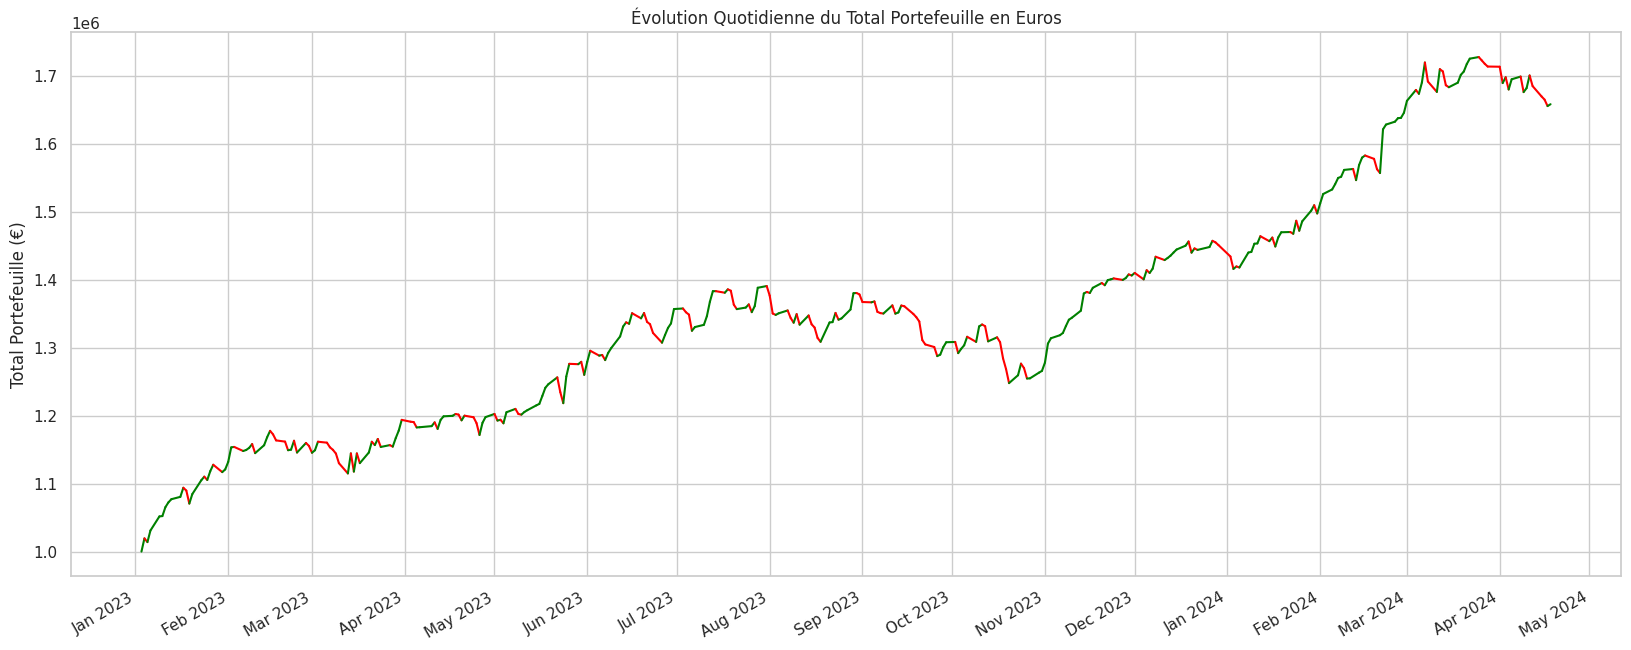

In [432]:
# GRAPH OF MY PORTFOLIO SINCE 03-01-2023

# Calculer la valeur de chaque société chaque jour
valeur_par_societe = data.multiply(nombre_actions, axis=1)

# Calculer le total des sociétés sélectionnées
valeur_par_societe['Total Portefeuille (€)'] = valeur_par_societe.sum(axis=1)

# Calculer la variation journalière en pourcentage
valeur_par_societe['Variation (%)'] = valeur_par_societe['Total Portefeuille (€)'].pct_change()

# Réinitialiser l'index pour que 'Date' soit une colonne
valeur_par_societe.reset_index(inplace=True)

# Créer un graphique pour l'évolution du total portefeuille quotidien
plt.figure(figsize=(20, 8))

# Parcourir les valeurs et tracer une ligne continue avec des couleurs conditionnelles
prev_val = valeur_par_societe['Total Portefeuille (€)'].iloc[0]
for i in range(1, len(valeur_par_societe)):
    color = 'green' if valeur_par_societe['Variation (%)'].iloc[i] > 0 else 'red'
    plt.plot(valeur_par_societe['Date'].iloc[i-1:i+1],
             valeur_par_societe['Total Portefeuille (€)'].iloc[i-1:i+1],
             linestyle='-', color=color)

# Définir le format de la date sur l'axe des abscisses pour afficher uniquement les mois
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # Rotation des dates pour mieux les afficher

# Ajouter les titres et les labels
plt.title('Évolution Quotidienne du Total Portefeuille en Euros')
plt.xlabel('')
plt.ylabel('Total Portefeuille (€)')
plt.grid(True)
# Afficher le graphique
plt.show()

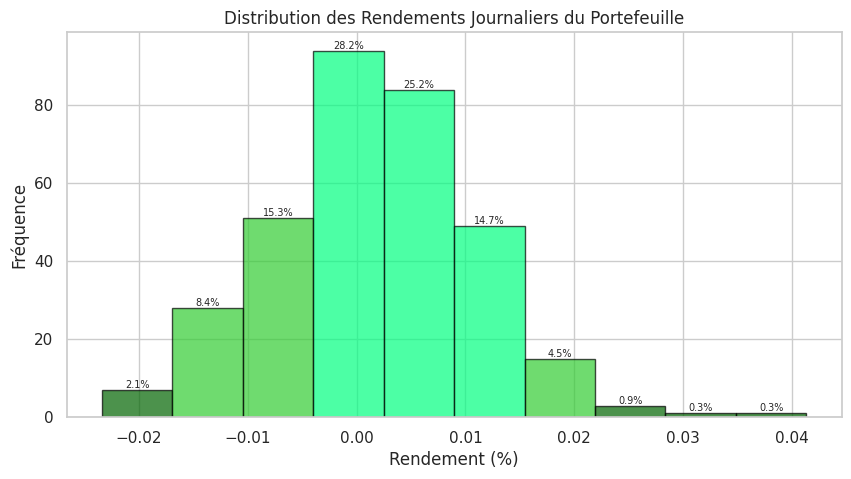

In [433]:
# DAILY RETURN DISTRIBUTION OF MY PORTFOLIO SINCE 03-01-2023

# Supprimer les valeurs NaN pour éviter des erreurs dans les calculs
rendements_journaliers = valeur_par_societe['Variation (%)'].dropna()

plt.figure(figsize=(10, 5))
# Réduire le nombre de bins pour avoir moins de barres
n, bins, patches = plt.hist(rendements_journaliers, bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Calcul des pourcentages pour chaque bin avec le nombre ajusté de bins
total = len(rendements_journaliers)
pourcentages = [(count / total) * 100 for count in n]

# Ajout des étiquettes de pourcentage au-dessus de chaque barre
for rect, pct in zip(patches, pourcentages):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f"{pct:.1f}%", ha='center', va='bottom', fontsize=7)

# Mise en couleur des barres selon les nouveaux critères de rendements
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if -0.01 <= leftside <= 0.01:
        patch.set_facecolor('springgreen')  # Rendements entre -1% et 1%
    elif -0.02 <= leftside <= 0.02:
        patch.set_facecolor('limegreen')  # Rendements entre -2% et 2%
    elif leftside:
        patch.set_facecolor('darkgreen')

plt.title('Distribution des Rendements Journaliers du Portefeuille')
plt.xlabel('Rendement (%)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [434]:
# PORTFOLIO VOLATILITY SINCE 03-01-2023

# Supprimer les valeurs NaN pour éviter des erreurs dans les calculs
rendements_journaliers = valeur_par_societe['Variation (%)'].dropna()

# Calcul du rendement quotidien moyen
mean_daily_return = np.mean(rendements_journaliers)

# Calcul de la volatilité (écart-type des rendements journaliers)
volatility = np.std(rendements_journaliers)
mean_daily_return_percentage = mean_daily_return * 100
volatility_percentage = volatility * 100

# Calcul de la volatilité annuelle à partir de la volatilité journalière
volatilite_annuelle_percentage = volatility_percentage * np.sqrt(252)

# Tableau
data_horizontal = [
    ["Rendement quotidien moyen", "Volatilité journalière ", "Volatilité annuelle "],
    [f"{mean_daily_return * 100:.3f}%", f"{volatility_percentage:.4f}%", f"{volatilite_annuelle_percentage:.2f}%"]
]

# Utilisation de tabulate pour formater le tableau en ligne horizontale
table_horizontal = tabulate(data_horizontal, headers="firstrow", tablefmt="grid")

print(table_horizontal)

+-----------------------------+---------------------------+------------------------+
| Rendement quotidien moyen   | Volatilité journalière    | Volatilité annuelle    |
+=============================+===========================+========================+
| 0.156%                      | 0.9183%                   | 14.58%                 |
+-----------------------------+---------------------------+------------------------+


In [435]:
# BENCHMARK EVOLUTION SINCE 03-01-2023

# Définition des tickers et des informations d'achat
tickers = {
    'CAC 40': '^FCHI',
    'S&P 500': '^GSPC',
    'Euro Stoxx 50': '^STOXX50E',
    'BlackRock US Growth': '0P00000AWD',
    'NASDAQ Composite': '^IXIC',
    'DAX': '^GDAXI',
    'MSCI World': 'URTH',
    'Amundi MSCI Europe Growth': 'CG9.PA'
}
purchase_date = "2023-01-03"

# Télécharger les données historiques et calculer les valeurs d'investissement
combined_data = pd.DataFrame()
for name, ticker in tickers.items():
    data = yf.download(ticker, start=purchase_date, end=pd.Timestamp.now().strftime("%Y-%m-%d"))
    data.fillna(method='ffill', inplace=True)
    opening_price = data.loc[purchase_date]['Close']
    units_purchased = montant_total / opening_price
    data['Investment Value (€)'] = units_purchased * data['Close']
    data['Daily Variation (%)'] = data['Investment Value (€)'].pct_change() * 100
    combined_data[name + ' Investment Value (€)'] = data['Investment Value (€)']
    combined_data[name + ' Daily Variation (%)'] = data['Daily Variation (%)']


# Vérifier si la date d'achat est présente dans l'index
if purchase_date not in combined_data.index:
    print(f"La date d'achat {purchase_date} n'est pas présente dans les données téléchargées.")

# Appliquer un remplissage vers l'avant pour toutes les valeurs manquantes
combined_data.fillna(method='ffill', inplace=True)
combined_data.fillna(0, inplace=True)

# Fonction pour formater les variations avec des couleurs
def format_variation_with_color(value):
    value = float(value)
    if value > 0:
        return f"\033[92m{value:.2f}%\033[0m"  # Vert
    elif value < 0:
        return f"\033[91m{value:.2f}%\033[0m"  # Rouge
    else:
        return f"{value:.2f}%"  # Neutre

# Formater les colonnes d'investissement pour inclure le symbole euro
def format_investment_value_with_euro(value):
    return f"€{int(value):,}".replace(',', ' ')

# Appliquer le formatage
for column in combined_data.columns:
    if 'Investment Value' in column:
        combined_data[column] = combined_data[column].apply(format_investment_value_with_euro)
    elif 'Variation' in column:
        combined_data[column] = combined_data[column].apply(format_variation_with_color)

# Formatter l'index pour la date
combined_data.index = combined_data.index.strftime('%d %b, %Y')

# Sélectionner les 7 premières et 7 dernières lignes
first_last_combined = pd.concat([combined_data.head(7), combined_data.tail(7)])

# Convertir le DataFrame sélectionné en liste de listes pour tabulate
table_data = first_last_combined.reset_index().values.tolist()

# Utiliser tabulate pour afficher le tableau
headers = ['Date'] + list(first_last_combined.columns)  # Ajouter 'Date' à la liste des en-têtes si l'index est la date
print(tabulate(table_data, headers=headers, tablefmt='fancy_grid', showindex=False))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


╒══════════════╤═══════════════════════════════╤══════════════════════════════╤════════════════════════════════╤═══════════════════════════════╤══════════════════════════════════════╤═════════════════════════════════════╤════════════════════════════════════════════╤═══════════════════════════════════════════╤═════════════════════════════════════════╤════════════════════════════════════════╤════════════════════════════╤═══════════════════════════╤═══════════════════════════════════╤══════════════════════════════════╤══════════════════════════════════════════════════╤═════════════════════════════════════════════════╕
│ Date         │ CAC 40 Investment Value (€)   │ CAC 40 Daily Variation (%)   │ S&P 500 Investment Value (€)   │ S&P 500 Daily Variation (%)   │ Euro Stoxx 50 Investment Value (€)   │ Euro Stoxx 50 Daily Variation (%)   │ BlackRock US Growth Investment Value (€)   │ BlackRock US Growth Daily Variation (%)   │ NASDAQ Composite Investment Value (€)   │ NASDAQ Composite Daily V

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


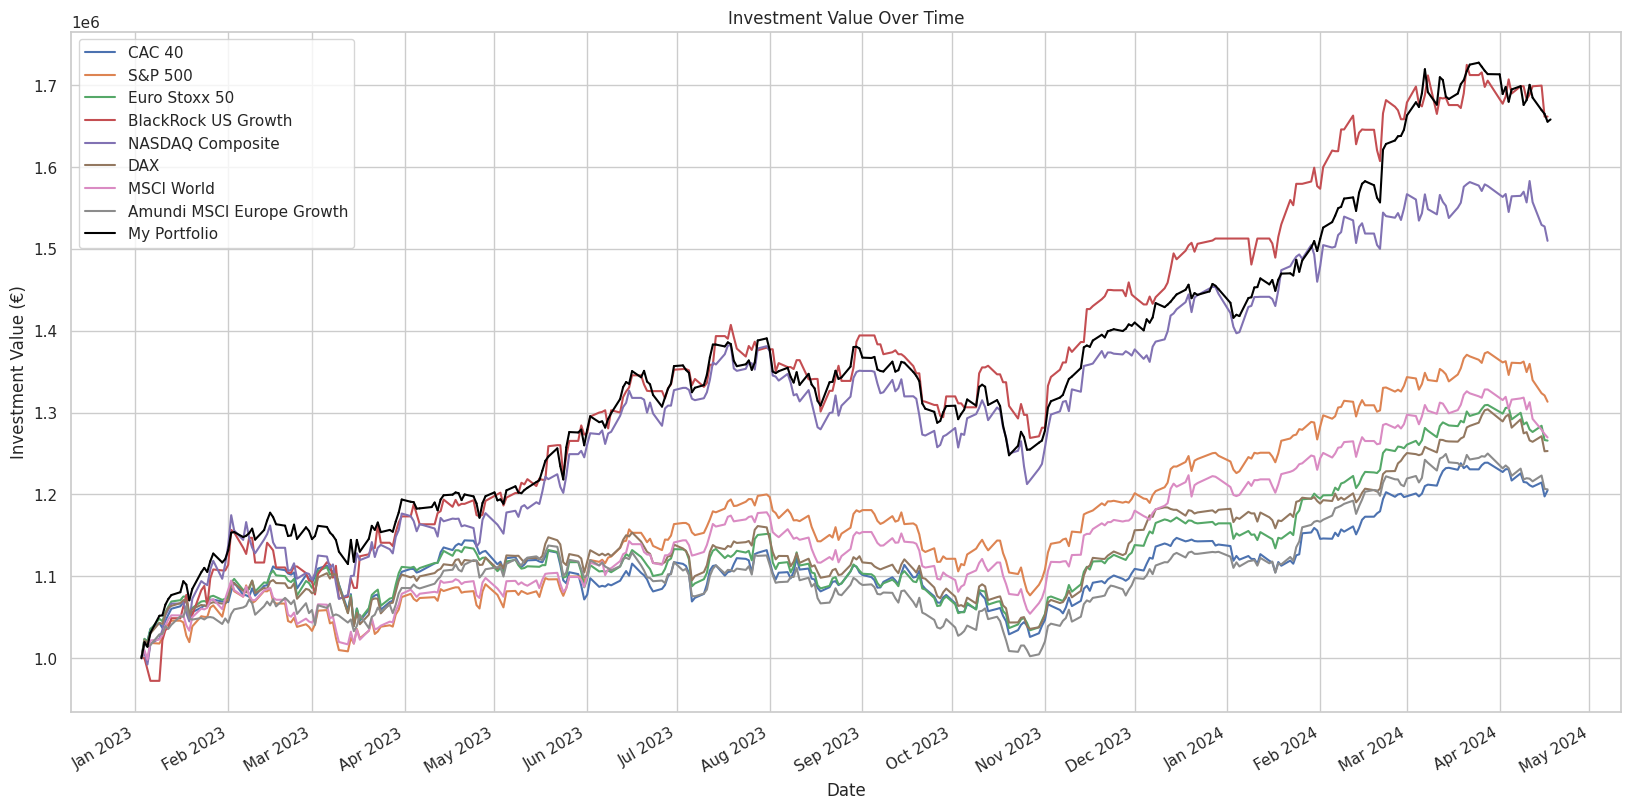

In [436]:
# GRAPH OF MY PORTFOLIO AND BENCHMARK SINCE 03-01-2023

# Téléchargement des données historiques et calcul des valeurs d'investissement
investment_values = pd.DataFrame()
for name, ticker in tickers.items():
    data = yf.download(ticker, start=purchase_date, end=pd.Timestamp.now().strftime("%Y-%m-%d"))
    data.fillna(method='ffill', inplace=True)
    if purchase_date not in data.index:
        continue
    opening_price = data.loc[purchase_date]['Close']
    units_purchased = montant_total / opening_price
    investment_values[name] = units_purchased * data['Close']

investment_values.fillna(method='ffill', inplace=True)
investment_values.fillna(method='bfill', inplace=True)

# Tracé des graphiques pour chaque indice avec une taille agrandie
plt.figure(figsize=(20, 10))  # Ajustement de la taille du graphique
for column in investment_values.columns:
    plt.plot(investment_values.index, investment_values[column], label=column)

# Tracer la courbe de "Mon Portefeuille"
for i in range(1, len(valeur_par_societe)):
    plt.plot(valeur_par_societe['Date'].iloc[i-1:i+1],
             valeur_par_societe['Total Portefeuille (€)'].iloc[i-1:i+1],
             linestyle='-', color='black', label='My Portfolio' if i == 1 else "")

# Appeler plt.legend() après avoir tracé toutes les courbes
plt.legend()

# Configuration du format de date sur l'axe des abscisses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotation des dates pour une meilleure lisibilité
plt.gcf().autofmt_xdate()

plt.title('Investment Value Over Time')
plt.xlabel('Date')
plt.ylabel('Investment Value (€)')
plt.legend()
plt.grid(True)
plt.show()

In [437]:
import warnings
import pandas as pd
import yfinance as yf
from tabulate import tabulate

warnings.filterwarnings('ignore', category=FutureWarning)

tickers = {
    'CAC 40': '^FCHI',
    'S&P 500': '^GSPC',
    'Euro Stoxx 50': '^STOXX50E',
    'BlackRock US Growth': '0P00000AWD',
    'NASDAQ Composite': '^IXIC',
    'DAX': '^GDAXI',
    'MSCI World': 'URTH',
    'Amundi MSCI Europe Growth': 'CG9.PA'
}

montant_initial = montant_total

# Valeur Final My Portfolio
total_valeur = round(portfolio_df['Valeur Totale € Num'].sum(), 0)
performance_portefeuille = ((total_valeur - montant_initial) / montant_initial) * 100

# Initialisation du DataFrame
rows = [{
    'Indice': 'My Portfolio',
    'Valeur Finale': f"€{total_valeur:,.2f}",
    'Performance (%)': f"{performance_portefeuille:.2f}%"
}]

# Ajout des données pour chaque indice
for indice, ticker in tickers.items():
    data = yf.download(ticker, start="2023-01-03")['Adj Close']
    valeur_finale = (data.iloc[-1] / data.iloc[0]) * montant_initial
    difference_valeur = valeur_finale - total_valeur
    difference_valeur_percent = (difference_valeur / 10000)  # Ajustement du calcul pour la différence en %

    rows.append({
        'Indice': indice,
        'Valeur Finale': f"€{valeur_finale:,.2f}",
        'Performance (%)': f"{((valeur_finale - montant_initial) / montant_initial) * 100:.2f}%",
        'Différence de Valeur (€)': f"€{difference_valeur:,.2f}",
        'Différence de Valeur (%)': f"{difference_valeur_percent:.2f}%"
    })

# Création du DataFrame
valeurs_finales_indices = pd.DataFrame(rows)

# Trier le DataFrame par la colonne 'Performance (%)' de manière décroissante
valeurs_finales_indices.sort_values('Performance (%)', ascending=False, inplace=True)

# Supprimer le signe '%' et convertir en float avant le tri si nécessaire
valeurs_finales_indices['Performance (%)'] = valeurs_finales_indices['Performance (%)'].str.rstrip('%').astype(float)

# Trier le DataFrame par la colonne 'Performance (%)' de manière décroissante
valeurs_finales_indices.sort_values('Performance (%)', ascending=False, inplace=True)

# Réappliquer le format de pourcentage après avoir effectué la conversion de type nécessaire
valeurs_finales_indices['Performance (%)'] = valeurs_finales_indices['Performance (%)'].apply(lambda x: f"{x:.2f}%")

# Affichage
print(tabulate(valeurs_finales_indices, headers='keys', tablefmt='fancy_grid', numalign="right"))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


╒════╤═══════════════════════════╤═════════════════╤═══════════════════╤════════════════════════════╤════════════════════════════╕
│    │ Indice                    │ Valeur Finale   │ Performance (%)   │ Différence de Valeur (€)   │ Différence de Valeur (%)   │
╞════╪═══════════════════════════╪═════════════════╪═══════════════════╪════════════════════════════╪════════════════════════════╡
│  4 │ BlackRock US Growth       │ €1,661,699.49   │ 66.17%            │ €3,479.49                  │ 0.35%                      │
├────┼───────────────────────────┼─────────────────┼───────────────────┼────────────────────────────┼────────────────────────────┤
│  0 │ My Portfolio              │ €1,658,220.00   │ 65.82%            │ nan                        │ nan                        │
├────┼───────────────────────────┼─────────────────┼───────────────────┼────────────────────────────┼────────────────────────────┤
│  5 │ NASDAQ Composite          │ €1,509,906.58   │ 50.99%            │ €-148,313.

In [418]:
# AMOUNT OF DIVIDENDS RECEIVED SINCE 03-01-2023 (NOT REINVESTED)

warnings.filterwarnings('ignore', category=FutureWarning)

# Définir votre liste de tickers et leur correspondance en noms
tickers = ["SAP", "OR.PA", "SQI.PA", "MA", "FDE.PA", "SU.PA", "DSY.PA", "MC.PA",
           "AIR.PA", "HO.PA", "GE", "NEOEN.PA", "2FE.DE", "RBT.PA", "AI.PA", "GTT.PA", "RMS.PA", "NVDA", "BLQA.F", "TSLA"]

tickers_to_names = {
    "SAP": "SAP",
    "OR.PA": "L'Oréal",
    "SQI.PA": "SQLI",
    "MA": "MasterCard",
    "FDE.PA": "La Française de l'Énergie",
    "SU.PA": "Schneider Electric",
    "DSY.PA": "Dassault Systèmes",
    "MC.PA": "LVMH",
    "AIR.PA": "Airbus",
    "HO.PA": "Thales",
    "GE": "General Electric",
    "NEOEN.PA": "Neoen",
    "2FE.DE": "Ferrari",
    "RBT.PA": "Robertet",
    "AI.PA": "Air Liquide",
    "GTT.PA": "Gaztransport & Technigaz",
    "RMS.PA": "Hermès International",
    "NVDA": "NVIDIA Corporation",
    "BLQA.F": "BlackRock",
    "TSLA": "Tesla, Inc."
}

start_date = "2023-01-03"

dividends_data = []
total_dividends_received = 0

for ticker in tickers:
    stock = yf.Ticker(ticker)
    dividends = stock.dividends[start_date:]
    nombre_d_actions = nombre_actions[ticker]  # Assurez-vous que ce dictionnaire est correctement défini

    for date, dividend in dividends.items():
        montant_percu = dividend * nombre_d_actions
        total_dividends_received += montant_percu
        nom_societe = tickers_to_names[ticker]

        dividends_data.append({
            "Société": nom_societe,
            "Date de Versement": date.strftime('%Y-%m-%d'),
            "Dividende Unitaire (€)": f"{dividend:.2f}",
            "Nombre d'Actions": nombre_d_actions,
            "Montant Perçu (€)": f"{montant_percu:.2f}"
        })

dividends_df = pd.DataFrame(dividends_data)

# Ajout de la ligne totalisant les dividendes reçus
total_row = pd.DataFrame([{
    "Société": "Total Dividendes Perçus",
    "Date de Versement": "",
    "Dividende Unitaire (€)": "",
    "Nombre d'Actions": "",
    "Montant Perçu (€)": f"{total_dividends_received:.2f}"
}])

dividends_df = pd.concat([dividends_df, total_row], ignore_index=True)

if not dividends_df.empty:
    print("Dividendes versés à partir du 3 janvier 2023 :")
    print(dividends_df.to_string(index=False))
else:
    print("Aucun dividende versé à partir du 3 janvier 2023 pour les tickers sélectionnés.")

Dividendes versés à partir du 3 janvier 2023 :
                 Société Date de Versement Dividende Unitaire (€) Nombre d'Actions Montant Perçu (€)
                     SAP        2023-05-12                   2.19           542.04           1184.89
                 L'Oréal        2023-04-26                   6.00           167.40           1004.42
              MasterCard        2023-01-06                   0.57           158.77             90.50
              MasterCard        2023-04-05                   0.57           158.77             90.50
              MasterCard        2023-07-06                   0.57           158.77             90.50
              MasterCard        2023-10-05                   0.57           158.77             90.50
              MasterCard        2024-01-08                   0.66           158.77            104.79
              MasterCard        2024-04-08                   0.66           158.77            104.79
      Schneider Electric        2023-05-09  

In [419]:
# FOURTH PARTS :
# MONTE CARLO SIMULATION OF MY PORTFOLIO OVER THE NEXT 30 YEARS

# Définition d'une fonction de format personnalisé pour inclure des espaces comme séparateurs de milliers et le symbole Euro
def format_with_spaces_and_euro(x):
    return "{:,.0f} €".format(x).replace(",", " ")

# Définition de la fonction de simulation de Monte Carlo
def simulation_monte_carlo(investment, expected_return, volatility, num_simulations):
    returns = np.random.normal(expected_return, volatility, num_simulations)
    ending_values = investment * (1 + returns)
    return ending_values

# Paramètres de simulation initiaux
investment_amount = 1000000  # 1 million d'euros
expected_return = 0.075  # Rendement annuel attendu (8%)
# Calcul de la volatilité annuelle à partir de la volatilité journalière
volatilite_annuelle_percentage = volatility_percentage * np.sqrt(252) / 100
volatility = volatilite_annuelle_percentage
num_simulations = 10000  # Nombre de simulations
num_years = 30  # Nombre d'années de simulation

# Boucle pour simuler année par année
for year in range(1, num_years + 1):
    # Simulation de Monte Carlo pour l'année actuelle
    ending_values = simulation_monte_carlo(investment_amount, expected_return, volatility, num_simulations)

    # Calcul de l'investissement initial pour l'année suivante (montant à la fin de l'année actuelle)
    investment_amount = np.mean(ending_values)

    # Calcul des statistiques pour l'année actuelle
    mean_value = np.mean(ending_values)
    above_25_percent = np.percentile(ending_values, 25)
    above_10_percent = np.percentile(ending_values, 10)
    above_60_percent = np.percentile(ending_values, 60)
    above_50_percent = np.percentile(ending_values, 50)
    above_75_percent = np.percentile(ending_values, 75)
    above_90_percent = np.percentile(ending_values, 90)

    # Calcul du pourcentage au-dessus de 1 million d'euros pour l'année actuelle
    above_1m_percent = (ending_values > 1000000).sum() / num_simulations * 100
    below_1m_percent = 100 - above_1m_percent

    # Affichage des résultats uniquement pour les trois premières et les trois dernières années
    if year <= 3 or year >= num_years - 2:
        # Formatage des cellules de moyenne en noir foncé
        formatted_mean_value = "\033[1;30m{}\033[0m".format(format_with_spaces_and_euro(mean_value))

        results_table_year = [
            ["La moyenne pour l'année {}".format(year), formatted_mean_value],
            ["Dans 90% des cas je suis au dessus de :", format_with_spaces_and_euro(above_10_percent)],
            ["Dans 75% des cas je suis au dessus de :", format_with_spaces_and_euro(above_25_percent)],
            ["Dans 50% des cas je suis au dessus de", format_with_spaces_and_euro(above_50_percent)],
            ["Dans 25% des cas je suis au dessus de", format_with_spaces_and_euro(above_75_percent)],
            ["Dans 10% des cas je suis au dessus de", format_with_spaces_and_euro(above_90_percent)],
            ["Dans {:.2f}% des cas mon investissement est au dessus de 1 million d'euros.".format(above_1m_percent)],
            ["Dans {:.2f}% des cas mon investissement est en dessous de 1 million d'euros.".format(below_1m_percent)]
        ]

        # Affichage du tableau pour l'année actuelle
        print("Résultats de la simulation pour l'année {} :".format(year))
        print(tabulate(results_table_year, headers=["Indicateur", "Valeur"]))
        print()

Résultats de la simulation pour l'année 1 :
Indicateur                                                                   Valeur
---------------------------------------------------------------------------  -----------
La moyenne pour l'année 1                                                    1 077 415 €
Dans 90% des cas je suis au dessus de :                                      888 781 €
Dans 75% des cas je suis au dessus de :                                      978 989 €
Dans 50% des cas je suis au dessus de                                        1 078 094 €
Dans 25% des cas je suis au dessus de                                        1 176 554 €
Dans 10% des cas je suis au dessus de                                        1 263 648 €
Dans 70.21% des cas mon investissement est au dessus de 1 million d'euros.
Dans 29.79% des cas mon investissement est en dessous de 1 million d'euros.

Résultats de la simulation pour l'année 2 :
Indicateur                                               